In [22]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [23]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data.dropna(), bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(data.dropna())
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


# Step 1: Calculate CSF r-value for Equipment

We'll calculate the Contest Success Function (CSF) r-value using equipment values from both teams. The CSF formula is:

$$P(\text{win}) = \frac{x^r}{x^r + y^r}$$

Where:
- $x$ = higher equipment value
- $y$ = lower equipment value
- $r$ = parameter we estimate using Maximum Likelihood Estimation (MLE)

In [24]:
from scipy.optimize import minimize_scalar

# Query to get equipment values for both teams per round
query = """
SELECT 
    r.id,
	r.match_id,
    r.id_demo_exports,
	r.round_num,
    r.ct_winner,
    r.team1_winner,
    r.is_ct_t1,
    r.round_end_reason,
    -- CT team equipment
    SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
    -- T team equipment
    SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
    -- Higher and lower equipment
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as higher_equipment,
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) <= 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as lower_equipment,
    -- Did the higher equipment team win?
    CASE 
        WHEN (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
              SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND r.ct_winner)
        OR (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) < 
            SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND NOT r.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won
FROM rounds_ed r
JOIN player_round_ed pr ON r.id = pr.round_id 
WHERE pr.eq_val_fte > 0  -- Valid equipment values
GROUP BY 1,2,3,4,5,6,7,8
HAVING SUM(CASE WHEN pr.team = 1 THEN pr.eq_val_fte ELSE 0 END) > 0
   AND SUM(CASE WHEN pr.team = 2 THEN pr.eq_val_fte ELSE 0 END) > 0
ORDER BY 1,2,3,4
"""

print("📊 Fetching equipment data from database...")
equipment_df = pd.read_sql_query(query, conn)
print(f"✅ Loaded {len(equipment_df):,} rounds")
print(f"   Matches: {equipment_df['match_id'].nunique():,}")
print(f"   Demos: {equipment_df['id_demo_exports'].nunique():,}")
print()

# Display sample data
print("Sample data:")
print(equipment_df.head(10))
print()
print("Data summary:")
print(equipment_df.describe())

📊 Fetching equipment data from database...


C:\Users\peter\AppData\Local\Temp\ipykernel_3136\3762691667.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  equipment_df = pd.read_sql_query(query, conn)


✅ Loaded 2,601,592 rounds
   Matches: 53,582
   Demos: 98,937

Sample data:
     id  match_id  id_demo_exports  round_num  ct_winner  team1_winner  \
0  5891   2366874              184          1       True         False   
1  5892   2366874              184          2       True         False   
2  5893   2366874              184          3       True         False   
3  5894   2366874              184          4      False          True   
4  5895   2366874              184          5      False          True   
5  5896   2366874              184          6      False          True   
6  5897   2366874              184          7      False          True   
7  5898   2366874              184          8      False          True   
8  5899   2366874              184          9       True         False   
9  5900   2366874              184         10      False          True   

   is_ct_t1  round_end_reason  ct_equipment  t_equipment  higher_equipment  \
0     False                 8  

In [25]:
# Define CSF log-likelihood function for MLE
def csf_log_likelihood(r, x, y, actual_wins):
    """
    Calculate negative log-likelihood for CSF model
    
    Parameters:
    - r: CSF parameter
    - x: higher equipment values
    - y: lower equipment values
    - actual_wins: 1 if higher equipment won, 0 otherwise
    """
    # Avoid division by zero and numerical issues
    r = max(r, 0.01)
    
    # Calculate predicted probabilities
    x_r = np.power(x, r)
    y_r = np.power(y, r)
    predicted_prob = x_r / (x_r + y_r)
    
    # Clip probabilities to avoid log(0)
    predicted_prob = np.clip(predicted_prob, 1e-10, 1 - 1e-10)
    
    # Calculate log-likelihood
    log_likelihood = np.sum(
        actual_wins * np.log(predicted_prob) + 
        (1 - actual_wins) * np.log(1 - predicted_prob)
    )
    
    # Return negative (for minimization)
    return -log_likelihood

# Estimate r-value using MLE
print("="*80)
print("🎯 CALCULATING CSF r-VALUE")
print("="*80)
print()

result = minimize_scalar(
    lambda r: csf_log_likelihood(r, 
                                equipment_df['higher_equipment'].values,
                                equipment_df['lower_equipment'].values,
                                equipment_df['higher_eq_won'].values),
    bounds=(0.01, 10),
    method='bounded'
)

csf_r_value = result.x

print(f"✅ Optimal r-value: {csf_r_value:.4f}")
print()
print(f"📊 Model Performance:")
print(f"   Higher equipment win rate: {equipment_df['higher_eq_won'].mean():.2%}")
print(f"   Log-likelihood: {-result.fun:.2f}")
print()

# Calculate predicted probabilities with optimal r
equipment_df['predicted_win_prob'] = (
    np.power(equipment_df['higher_equipment'], csf_r_value) / 
    (np.power(equipment_df['higher_equipment'], csf_r_value) + 
     np.power(equipment_df['lower_equipment'], csf_r_value))
)


print(f"💡 Interpretation:")
print(f"   r = {csf_r_value:.4f} means equipment advantage has ")
print()



🎯 CALCULATING CSF r-VALUE

✅ Optimal r-value: 1.0855

📊 Model Performance:
   Higher equipment win rate: 65.29%
   Log-likelihood: -1514257.48

✅ Optimal r-value: 1.0855

📊 Model Performance:
   Higher equipment win rate: 65.29%
   Log-likelihood: -1514257.48

💡 Interpretation:
   r = 1.0855 means equipment advantage has 

💡 Interpretation:
   r = 1.0855 means equipment advantage has 



# Step 2: Fetch Additional Round Data

Now we need to fetch data about:
1. **Round end reason** - How the round ended (elimination, bomb defused, time expired, etc.)
2. **Number of survivors** - How many players survived on the winning team
3. **Saved equipment** - Equipment value of survivors
4. **Money earned** - Money earned by teams

In [26]:
# Query for detailed round outcomes
query_detailed = """
WITH round_equipment AS (
    SELECT 
        r.id,
        r.match_id,
        r.id_demo_exports,
        r.round_num,
        r.ct_winner,
        r.team1_winner,
        r.is_ct_t1,
        r.round_end_reason,
        -- CT team equipment
        SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
        -- T team equipment
        SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    WHERE pr.eq_val_fte > 0
    GROUP BY 1,2,3,4,5,6,7,8
),
bomb_planted AS (
    SELECT 
        round_id,
        CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
    FROM bomb_events_round_ed
    WHERE bomb_event_type = 0
    GROUP BY round_id
),
round_survivors AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Count total players per team (5 players each)
        -- CT survivors = 5 - (deaths of CT players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
        END) as ct_survivors,
        -- T survivors = 5 - (deaths of T players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
        END) as t_survivors
    FROM rounds_ed r
    LEFT JOIN kills_round_ed k ON r.id = k.round_id
    LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
    GROUP BY 1,2
),
saved_equipment AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
        -- T team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
player_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)
            ELSE 0 END) as ct_player_money,
        -- T team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)  
            ELSE 0 END) as t_player_money
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
)
SELECT 
    re.*,
    -- Add bomb planted status
    COALESCE(bp.bomb_planted, 0) as bomb_planted,
    -- Add survivor counts from round_survivors CTE
    rs.ct_survivors,
    rs.t_survivors,
    -- Higher and lower equipment
    CASE 
        WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as higher_equipment,
    CASE 
        WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as lower_equipment,
    -- Did higher equipment team win?
    CASE 
        WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
        OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won,
    -- Winner's survivors (only from is_alive_re)
    CASE 
        WHEN re.ct_winner THEN rs.ct_survivors
        ELSE rs.t_survivors
    END as winner_survivors,
    -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
    CASE 
        WHEN re.ct_winner THEN se.ct_saved_equipment
        ELSE se.t_saved_equipment
    END as winner_saved_equipment,
    -- CT and T saved equipment 
    se.ct_saved_equipment,
    se.t_saved_equipment,
    -- All money columns for analysis
    pm.ct_player_money,
    pm.t_player_money
FROM round_equipment re
LEFT JOIN bomb_planted bp ON re.id = bp.round_id
LEFT JOIN round_survivors rs ON re.id = rs.round_id
LEFT JOIN saved_equipment se ON re.id = se.round_id
LEFT JOIN player_money pm ON re.id = pm.round_id
WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
ORDER BY re.match_id, re.round_num
"""

print("📊 Fetching detailed round data...")
detailed_df = pd.read_sql_query(query_detailed, conn)
print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
print()

# Combine round end reasons 12 and 7
print("🔹 Pre-processing: Combining round end reasons 12 and 7")
detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
print(f"   Round end reasons 12 merged into 7")
print()

# Calculate CSF predictions for this dataset
detailed_df['predicted_win_prob'] = (
    np.power(detailed_df['higher_equipment'], csf_r_value) / 
    (np.power(detailed_df['higher_equipment'], csf_r_value) + 
     np.power(detailed_df['lower_equipment'], csf_r_value))
)





📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_3136\479469435.py:127: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7



In [ ]:
print("="*80)
print("🔍 DATA QUALITY: FILTERING INCONSISTENT ROUNDS")
print("="*80)
print()

print(f"Original dataset: {len(detailed_df):,} rounds")
print()

# Filter out impossible survivor scenarios for elimination rounds


# Reason 9 (T Win Elimination): CT should have 0 survivors
before = len(detailed_df)
reason_9_issues = detailed_df[(detailed_df['round_end_reason'] == 9) & (detailed_df['ct_survivors'] > 0)]
detailed_df = detailed_df[~((detailed_df['round_end_reason'] == 9) & (detailed_df['ct_survivors'] > 0))]
filtered_9 = before - len(detailed_df)
if filtered_9 > 0:
    print(f"🔴 Filtered Reason 9 (T Win Elimination) with CT survivors > 0: {filtered_9:,} rounds ({filtered_9/before*100:.3f}%)")
    print(f"   Sample round IDs: {reason_9_issues['id'].head(5).tolist()}")

print()
total_filtered = filtered_9
original_count = len(detailed_df) + total_filtered



🔍 DATA QUALITY: FILTERING INCONSISTENT ROUNDS

Original dataset: 2,601,592 rounds

🔴 Filtered Reason 1 (Target Bombed) with CT survivors > 0: 383,971 rounds (14.759%)
   Sample round IDs: [2203598, 2203600, 2203616, 2203639, 2203642]
🔴 Filtered Reason 1 (Target Bombed) with CT survivors > 0: 383,971 rounds (14.759%)
   Sample round IDs: [2203598, 2203600, 2203616, 2203639, 2203642]
🔴 Filtered Reason 8 (CT Win Elimination) with T survivors > 0: 11,625 rounds (0.524%)
   Sample round IDs: [2202570, 2202575, 2202578, 2204146, 2204240]
🔴 Filtered Reason 8 (CT Win Elimination) with T survivors > 0: 11,625 rounds (0.524%)
   Sample round IDs: [2202570, 2202575, 2202578, 2204146, 2204240]
🔴 Filtered Reason 9 (T Win Elimination) with CT survivors > 0: 2,821 rounds (0.128%)
   Sample round IDs: [2199356, 2206738, 2204067, 2199148, 2199156]

✅ Clean dataset: 2,203,175 rounds
   Total filtered: 398,417 rounds (15.31%)

💡 These rounds had inconsistent data where elimination wins
   had survivors f

# Round End Reason Prediction Model

We'll analyze how round end reasons vary with CSF advantage. This helps the ABM predict realistic round outcomes based on equipment advantage.

In [ ]:
print("="*80)
print("📊 ROUND END REASON DISTRIBUTION BY CSF PERCENTAGE (CT & T SIDES)")
print("="*80)
print()

# Get top 4 round end reasons
top_reasons = detailed_df['round_end_reason'].value_counts().head(4).index.tolist()
reason_names = {
    1: "T Win (Target Bombed)",
    7: "CT Win (Defuse)",
    8: "CT Win (Elimination)", 
    9: "T Win (Elimination)",
}

print("Top 4 Round End Reasons:")
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    count = (detailed_df['round_end_reason'] == reason).sum()
    pct = count / len(detailed_df) * 100
    print(f"   {reason}: {reason_name} - {count:,} rounds ({pct:.2f}%)")
print()

# Create CSF percentage bins (0-100% in steps)
csf_bins = np.arange(0, 1.01, 0.01)  # 0%, 1%, 2%, ..., 100%
csf_labels = [f"{int(i*100)}" for i in csf_bins[:-1]]

detailed_df['csf_pct_bin'] = pd.cut(detailed_df['predicted_win_prob'], 
                                     bins=csf_bins, 
                                     labels=csf_labels,
                                     include_lowest=True,
                                     ordered=False)

# Analyze round end reason distributions by CSF percentage for CT and T sides
round_end_reason_analysis = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE ROUND END REASON DISTRIBUTIONS")
    print(f"{'='*80}\n")
    
    side_analysis = {}
    
    for csf_pct in range(50, 101):  # 50% to 100% CSF
        df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
        
        if len(df_csf) < 10:
            continue
        
        # Determine which rounds this side won
        if side == 'CT':
            df_side = df_csf[df_csf['ct_winner'] == True].copy()
        else:
            df_side = df_csf[df_csf['ct_winner'] == False].copy()
        
        if len(df_side) < 5:
            continue
        
        # Calculate distribution of round end reasons for this side's wins
        reason_counts = df_side['round_end_reason'].value_counts()
        total_rounds = len(df_side)
        
        reason_dist = {}
        for reason in top_reasons:
            count = reason_counts.get(reason, 0)
            prob = count / total_rounds if total_rounds > 0 else 0
            reason_dist[reason] = {
                'count': int(count),
                'probability': float(prob),
                'reason_name': reason_names.get(reason, f"Reason {reason}")
            }
        
        side_analysis[csf_pct] = {
            'n_rounds': total_rounds,
            'reason_distribution': reason_dist
        }
    
    # Print sample at key CSF percentages
    print(f"{side} Round End Reason Distribution by CSF%:")
    print(f"{'CSF%':<6} {'N':<8} {'Reason 1':<12} {'Reason 7':<12} {'Reason 8':<12} {'Reason 9':<12}")
    print(f"{'-'*70}")
    
    for csf_pct in [50, 60, 70, 80, 90, 100]:
        if csf_pct in side_analysis:
            data = side_analysis[csf_pct]
            reason_dist = data['reason_distribution']
            
            print(f"{csf_pct:<6} {data['n_rounds']:<8,} "
                  f"{reason_dist.get(1, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(7, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(8, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(9, {}).get('probability', 0):<12.4f}")
    
    round_end_reason_analysis[side] = side_analysis

print()
print("="*80)
print("✅ Round end reason distribution analysis complete")
print("="*80)
print()
print("💡 Use these distributions to sample round end reasons based on CSF advantage and side")


📊 ROUND END REASON DISTRIBUTION BY CSF PERCENTAGE (CT & T SIDES)

Top 4 Round End Reasons:
   8: CT Win (Elimination) - 922,913 rounds (41.89%)
   9: T Win (Elimination) - 851,720 rounds (38.66%)
   7: CT Win (Defuse/Time) - 405,067 rounds (18.39%)
   1: T Win (Target Bombed) - 23,475 rounds (1.07%)


🔹 CT SIDE ROUND END REASON DISTRIBUTIONS


🔹 CT SIDE ROUND END REASON DISTRIBUTIONS

CT Round End Reason Distribution by CSF%:
CSF%   N        Reason 1     Reason 7     Reason 8     Reason 9    
----------------------------------------------------------------------
50     115,925  0.0000       0.3807       0.6193       0.0000      
60     26,907   0.0000       0.3344       0.6656       0.0000      
70     11,000   0.0000       0.2999       0.7001       0.0000      
80     13,125   0.0000       0.2508       0.7492       0.0000      
90     14,749   0.0000       0.1713       0.8287       0.0000      

🔹 T SIDE ROUND END REASON DISTRIBUTIONS

CT Round End Reason Distribution by CSF%:
CSF%   

📊 Creating round end reason distribution visualization...



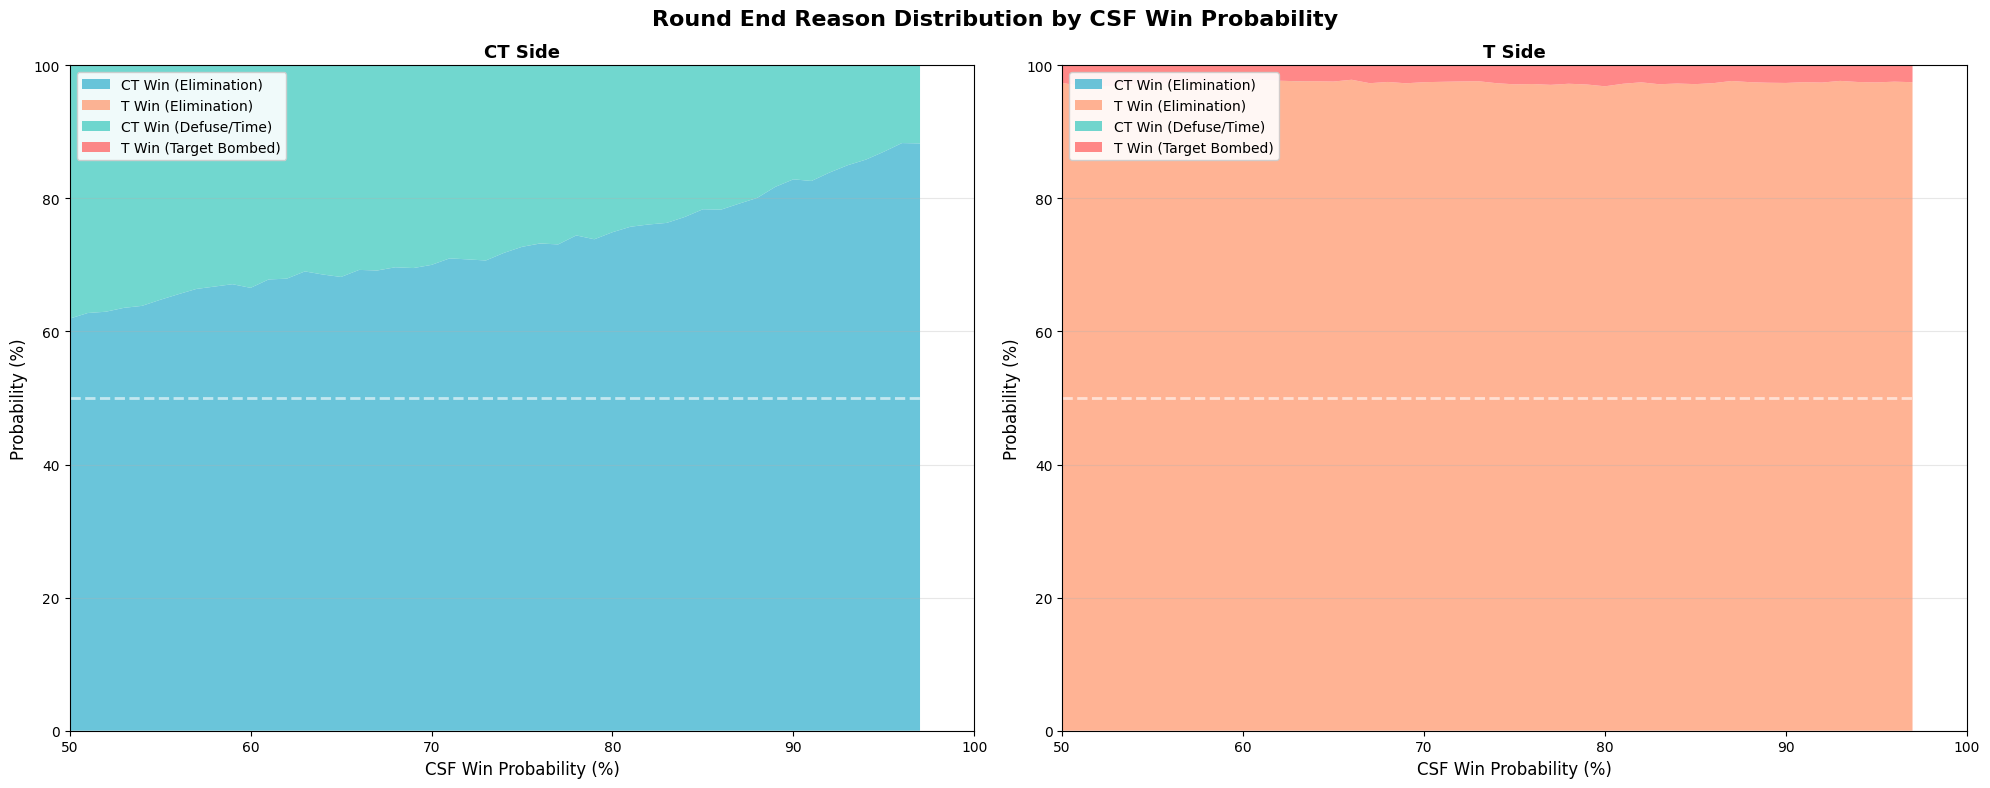

✅ Round end reason visualization complete!

💡 KEY INSIGHTS:
   CT SIDE:
   • When CT has equipment advantage, they win more by elimination (Reason 8)
   • Defuse/Time wins (Reason 7) represent successful defense

   T SIDE:
   • When T has equipment advantage, they win more by elimination (Reason 9)
   • Target Bombed (Reason 1) represents successful bomb detonation

   • Use these distributions in ABM to sample realistic round outcomes per side


In [29]:
# Visualize round end reason distributions with stacked area plots (CT and T sides)
print("📊 Creating round end reason distribution visualization...")
print()

# Create visualization for CT and T sides
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Round End Reason Distribution by CSF Win Probability', 
             fontsize=16, fontweight='bold')

# Define colors for each reason
colors = {
    1: '#FF6B6B',  # Red - Target Bombed (T Win)
    7: '#4ECDC4',  # Cyan - Defuse/Time (CT Win)
    8: '#45B7D1',  # Blue - Elimination (CT Win)
    9: '#FFA07A',  # Orange - Elimination (T Win)
}

for side_idx, side in enumerate(['CT', 'T']):
    ax = axes[side_idx]
    
    if side not in round_end_reason_analysis or not round_end_reason_analysis[side]:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=14)
        ax.set_xlabel('CSF Win Probability (%)', fontsize=12)
        ax.set_ylabel('Probability (%)', fontsize=12)
        ax.set_title(f'{side} Side', fontsize=13, fontweight='bold')
        continue
    
    side_data = round_end_reason_analysis[side]
    
    # Prepare data for stacked area plot
    csf_percentages = sorted(side_data.keys())
    reason_probs = {reason: [] for reason in top_reasons}
    
    for csf_pct in csf_percentages:
        data = side_data[csf_pct]
        reason_dist = data['reason_distribution']
        
        for reason in top_reasons:
            prob = reason_dist.get(reason, {}).get('probability', 0) * 100
            reason_probs[reason].append(prob)
    
    # Stack the areas
    y_data = np.array([reason_probs[reason] for reason in top_reasons])
    labels = [reason_names.get(reason, f"Reason {reason}") for reason in top_reasons]
    color_list = [colors.get(reason, 'gray') for reason in top_reasons]
    
    ax.stackplot(csf_percentages, y_data, 
                labels=labels,
                colors=color_list, alpha=0.8)
    
    # Formatting
    ax.set_xlabel('CSF Win Probability (%)', fontsize=12)
    ax.set_ylabel('Probability (%)', fontsize=12)
    ax.set_title(f'{side} Side', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xlim(50, 100)
    ax.set_ylim(0, 100)
    
    # Add reference line at 50%
    ax.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=2)

plt.tight_layout()
plt.show()

print("✅ Round end reason visualization complete!")
print()
print("💡 KEY INSIGHTS:")
print("   CT SIDE:")
print("   • When CT has equipment advantage, they win more by elimination (Reason 8)")
print("   • Defuse/Time wins (Reason 7) represent successful defense")
print()
print("   T SIDE:")
print("   • When T has equipment advantage, they win more by elimination (Reason 9)")
print("   • Target Bombed (Reason 1) represents successful bomb detonation")
print()
print("   • Use these distributions in ABM to sample realistic round outcomes per side")


In [30]:
print("="*80)
print("📊 BOMB PLANTED ANALYSIS BY CSF PERCENTAGE (CT & T SIDES)")
print("="*80)
print("   (Reasons 8 & 9: Elimination wins only)")
print()

# Analyze bomb planted rates by CSF percentage for CT and T sides
# Only look at reason 8 (CT Win Elimination) and reason 9 (T Win Elimination)
bomb_planted_analysis = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE BOMB PLANTED RATES")
    print(f"{'='*80}\n")
    
    side_analysis = {}
    
    for csf_pct in range(50, 101):  # 50% to 100% CSF
        df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
        
        if len(df_csf) < 10:
            continue
        
        # Determine which rounds this side won AND filter by elimination reasons only
        if side == 'CT':
            # CT wins by elimination (reason 8)
            df_side = df_csf[(df_csf['ct_winner'] == True) & 
                            (df_csf['round_end_reason'] == 8)].copy()
        else:
            # T wins by elimination (reason 9)
            df_side = df_csf[(df_csf['ct_winner'] == False) & 
                            (df_csf['round_end_reason'] == 9)].copy()
        
        if len(df_side) < 5:
            continue
        
        # Calculate bomb planted statistics
        total_rounds = len(df_side)
        bomb_planted_count = df_side['bomb_planted'].sum()
        bomb_planted_prob = bomb_planted_count / total_rounds if total_rounds > 0 else 0
        
        side_analysis[csf_pct] = {
            'n_rounds': total_rounds,
            'bomb_planted_count': int(bomb_planted_count),
            'bomb_planted_probability': float(bomb_planted_prob),
            'bomb_not_planted_probability': float(1 - bomb_planted_prob)
        }
    
    # Print sample at key CSF percentages
    print(f"{side} Bomb Planted Rate by CSF%:")
    print(f"{'CSF%':<6} {'N':<8} {'Planted':<12} {'Not Planted':<12}")
    print(f"{'-'*50}")
    
    for csf_pct in [50, 60, 70, 80, 90, 100]:
        if csf_pct in side_analysis:
            data = side_analysis[csf_pct]
            print(f"{csf_pct:<6} {data['n_rounds']:<8,} "
                  f"{data['bomb_planted_probability']:<12.4f} "
                  f"{data['bomb_not_planted_probability']:<12.4f}")
    
    bomb_planted_analysis[side] = side_analysis

print()
print("="*80)
print("✅ Bomb planted analysis complete (Reasons 8 & 9 only)")
print("="*80)
print()
print("💡 Use these distributions to determine bomb plant probability for elimination wins")
print("   • Reason 8 (CT Win Elimination): CT stopped T but bomb may have been planted")
print("   • Reason 9 (T Win Elimination): T eliminated CT and bomb may have been planted")

📊 BOMB PLANTED ANALYSIS BY CSF PERCENTAGE (CT & T SIDES)
   (Reasons 8 & 9: Elimination wins only)


🔹 CT SIDE BOMB PLANTED RATES

CT Bomb Planted Rate by CSF%:
CSF%   N        Planted      Not Planted 
--------------------------------------------------
50     71,794   0.0036       0.9964      
60     17,909   0.0023       0.9977      
70     7,701    0.0039       0.9961      
80     9,833    0.0032       0.9968      
90     12,222   0.0020       0.9980      

🔹 T SIDE BOMB PLANTED RATES

CT Bomb Planted Rate by CSF%:
CSF%   N        Planted      Not Planted 
--------------------------------------------------
50     71,794   0.0036       0.9964      
60     17,909   0.0023       0.9977      
70     7,701    0.0039       0.9961      
80     9,833    0.0032       0.9968      
90     12,222   0.0020       0.9980      

🔹 T SIDE BOMB PLANTED RATES

T Bomb Planted Rate by CSF%:
CSF%   N        Planted      Not Planted 
--------------------------------------------------
50     79,567   0.841

📊 Creating bomb planted distribution visualization...



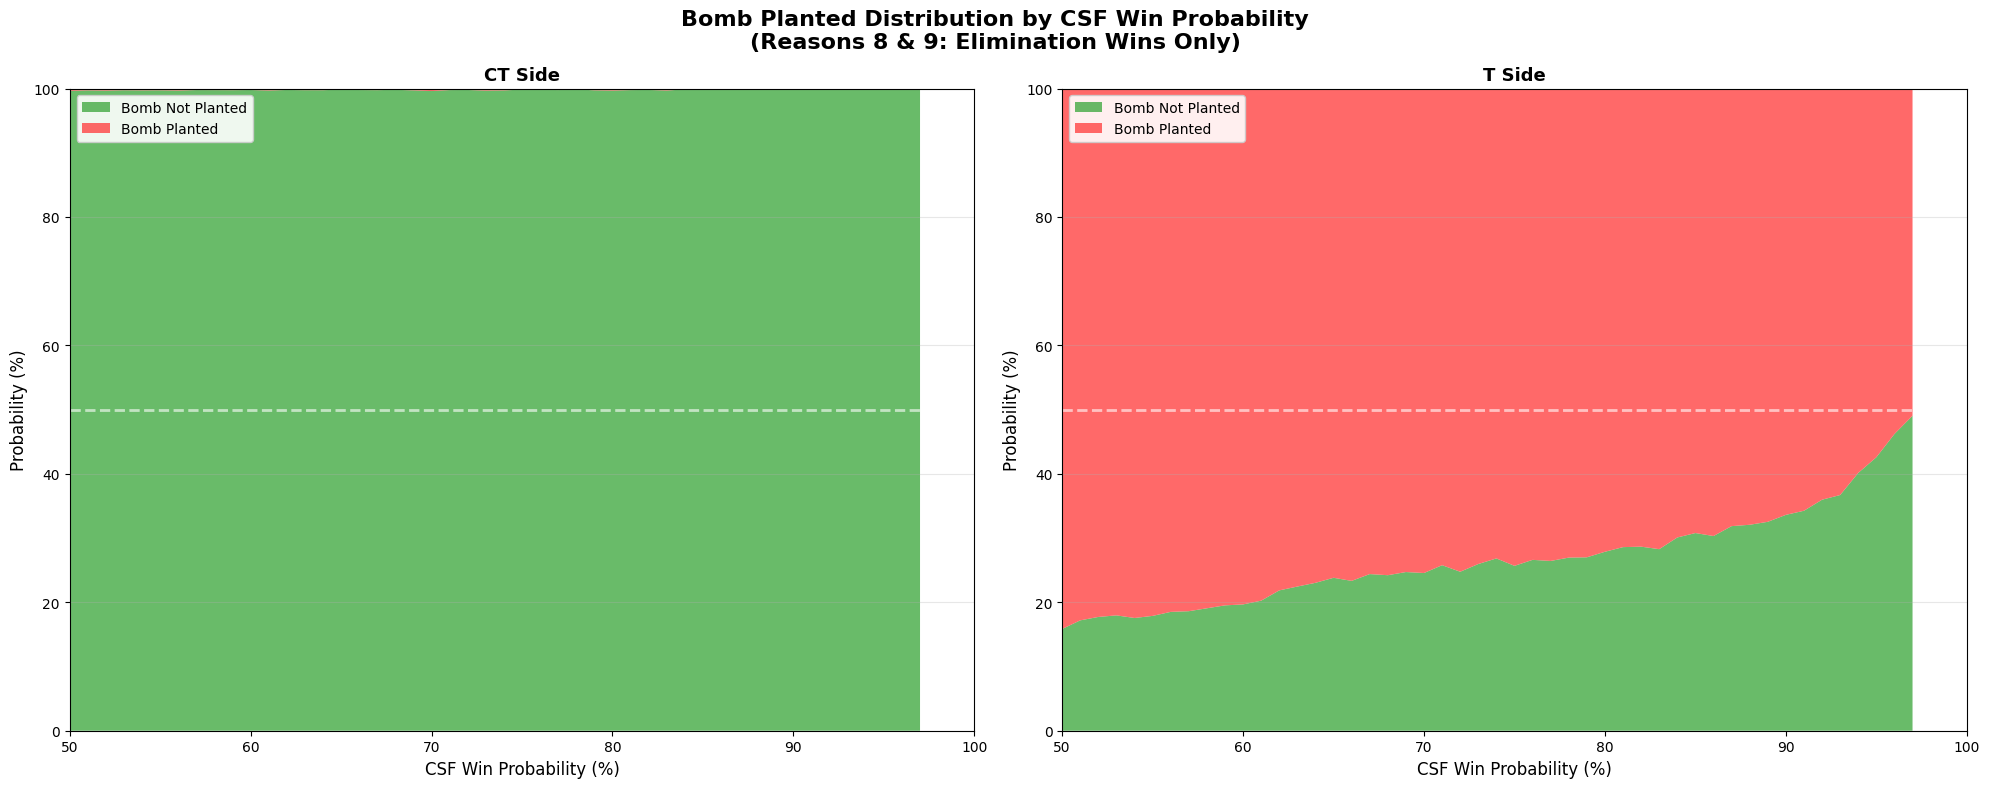

✅ Bomb planted visualization complete!

💡 KEY INSIGHTS:
   CT SIDE (Reason 8 - CT Win Elimination):
   • Shows bomb plant rate when CT wins by elimination
   • Bomb planted means T planted but CT eliminated them after

   T SIDE (Reason 9 - T Win Elimination):
   • Shows bomb plant rate when T wins by elimination
   • Bomb planted means T planted then eliminated CT

   • Use these distributions in ABM for elimination round scenarios


In [31]:
# Visualize bomb planted distributions with stacked area plots (CT and T sides)
print("📊 Creating bomb planted distribution visualization...")
print()

# Create visualization for CT and T sides
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Bomb Planted Distribution by CSF Win Probability\n(Reasons 8 & 9: Elimination Wins Only)', 
             fontsize=16, fontweight='bold')

# Define colors
colors_bomb = {
    'planted': '#FF4444',      # Red - Bomb Planted
    'not_planted': '#44AA44',  # Green - Bomb Not Planted
}

for side_idx, side in enumerate(['CT', 'T']):
    ax = axes[side_idx]
    
    if side not in bomb_planted_analysis or not bomb_planted_analysis[side]:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=14)
        ax.set_xlabel('CSF Win Probability (%)', fontsize=12)
        ax.set_ylabel('Probability (%)', fontsize=12)
        ax.set_title(f'{side} Side', fontsize=13, fontweight='bold')
        continue
    
    side_data = bomb_planted_analysis[side]
    
    # Prepare data for stacked area plot
    csf_percentages = sorted(side_data.keys())
    planted_probs = []
    not_planted_probs = []
    
    for csf_pct in csf_percentages:
        data = side_data[csf_pct]
        planted_probs.append(data['bomb_planted_probability'] * 100)
        not_planted_probs.append(data['bomb_not_planted_probability'] * 100)
    
    # Stack the areas
    y_data = np.array([not_planted_probs, planted_probs])
    labels = ['Bomb Not Planted', 'Bomb Planted']
    color_list = [colors_bomb['not_planted'], colors_bomb['planted']]
    
    ax.stackplot(csf_percentages, y_data, 
                labels=labels,
                colors=color_list, alpha=0.8)
    
    # Formatting
    ax.set_xlabel('CSF Win Probability (%)', fontsize=12)
    ax.set_ylabel('Probability (%)', fontsize=12)
    ax.set_title(f'{side} Side', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xlim(50, 100)
    ax.set_ylim(0, 100)
    
    # Add reference line at 50%
    ax.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=2)

plt.tight_layout()
plt.show()

print("✅ Bomb planted visualization complete!")
print()
print("💡 KEY INSIGHTS:")
print("   CT SIDE (Reason 8 - CT Win Elimination):")
print("   • Shows bomb plant rate when CT wins by elimination")
print("   • Bomb planted means T planted but CT eliminated them after")
print()
print("   T SIDE (Reason 9 - T Win Elimination):")
print("   • Shows bomb plant rate when T wins by elimination")
print("   • Bomb planted means T planted then eliminated CT")
print()
print("   • Use these distributions in ABM for elimination round scenarios")

# Survivor Prediction Model

We'll analyze the relationship between:
1. **CSF prediction** (win probability based on equipment advantage)
2. **Round end reason** (how the round ended)
3. **Number of survivors** (outcome)

This will help the ABM predict realistic survivor counts based on equipment advantage and round outcome.

In [32]:
print("="*80)
print("📊 SURVIVOR CUMULATIVE DISTRIBUTION BY CSF PERCENTAGE")
print("="*80)
print()

# Get top 4 round end reasons
top_reasons = detailed_df['round_end_reason'].value_counts().head(4).index.tolist()
reason_names = {
    1: "T Win (Target Bombed)",
    7: "CT Win (Defuse/Time)",
    8: "CT Win (Elimination)", 
    9: "T Win (Elimination)",
}

# Create CSF percentage bins (0-100% in steps)
csf_bins = np.arange(0, 1.01, 0.01)  # 0%, 1%, 2%, ..., 100%
csf_labels = [f"{int(i*100)}" for i in csf_bins[:-1]]

detailed_df['csf_pct_bin'] = pd.cut(detailed_df['predicted_win_prob'], 
                                     bins=csf_bins, 
                                     labels=csf_labels,
                                     include_lowest=True,
                                     ordered=False)

# Analyze survivor cumulative distributions for BOTH CT and T (winners and losers)
survivor_analysis = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE SURVIVOR CUMULATIVE DISTRIBUTIONS (Winners & Losers)")
    print(f"{'='*80}\n")
    
    side_analysis = {}
    
    for reason in top_reasons:
        reason_name = reason_names.get(reason, f"Reason {reason}")
        print(f"\n   🎯 {reason_name} (Reason {reason})")
        
        # Filter by round end reason only (not by winner)
        df_reason = detailed_df[detailed_df['round_end_reason'] == reason].copy()
        
        if len(df_reason) < 50:
            print(f"   ⚠️  Insufficient data ({len(df_reason)} rounds)")
            continue
        
        print(f"   Total rounds: {len(df_reason):,}")
        
        # Calculate cumulative distribution for each CSF percentage
        csf_data = {}
        
        for csf_pct in range(50, 101):  # 50% to 100% CSF
            df_csf = df_reason[df_reason['csf_pct_bin'] == str(csf_pct)].copy()
            
            if len(df_csf) < 5:
                continue
            
            # Get survivors for this side (regardless of winner/loser)
            survivor_col = 'ct_survivors' if side == 'CT' else 't_survivors'
            survivors = df_csf[survivor_col]
            
            # Calculate cumulative distribution
            surv_counts = survivors.value_counts().sort_index()
            total_rounds = len(survivors)
            
            # Cumulative probability for each survivor count (0-5)
            cumulative_dist = {}
            cumulative_prob = 0
            
            for surv_count in range(0, 6):
                count = surv_counts.get(surv_count, 0)
                prob = count / total_rounds
                cumulative_prob += prob
                cumulative_dist[surv_count] = {
                    'count': int(count),
                    'probability': float(prob),
                    'cumulative_probability': float(cumulative_prob)
                }
            
            csf_data[csf_pct] = {
                'n_samples': total_rounds,
                'mean_survivors': float(survivors.mean()),
                'median_survivors': float(survivors.median()),
                'cumulative_distribution': cumulative_dist
            }
        
        # Print sample at key CSF percentages
        print(f"\n   {side} Survivor Cumulative Distributions:")
        print(f"   {'CSF%':<6} {'N':<8} {'Mean':<7} {'CDF: 0':<9} {'1':<9} {'2':<9} {'3':<9} {'4':<9} {'5':<9}")
        print(f"   {'-'*80}")
        
        for csf_pct in [50, 60, 70, 80, 90, 100]:
            if csf_pct in csf_data:
                data = csf_data[csf_pct]
                cdf = data['cumulative_distribution']
                print(f"   {csf_pct:<6} {data['n_samples']:<8,} {data['mean_survivors']:<7.2f} "
                      f"{cdf[0]['cumulative_probability']:<9.4f} "
                      f"{cdf[1]['cumulative_probability']:<9.4f} "
                      f"{cdf[2]['cumulative_probability']:<9.4f} "
                      f"{cdf[3]['cumulative_probability']:<9.4f} "
                      f"{cdf[4]['cumulative_probability']:<9.4f} "
                      f"{cdf[5]['cumulative_probability']:<9.4f}")
        
        side_analysis[reason] = {
            'reason_name': reason_name,
            'csf_distributions': csf_data
        }
    
    survivor_analysis[side] = side_analysis

print("\n" + "="*80)
print("✅ SURVIVOR CUMULATIVE DISTRIBUTION ANALYSIS COMPLETE")
print("="*80)
print()
print("💡 Cumulative distributions show P(survivors ≤ N) for each CSF%")
print("   • Includes CT and T survivors for ALL rounds (winners and losers)")
print("   • Group by round_end_reason and side (CT/T)")
print("   • Use these to sample survivors: generate random [0,1], find where it falls in CDF")

📊 SURVIVOR CUMULATIVE DISTRIBUTION BY CSF PERCENTAGE


🔹 CT SIDE SURVIVOR CUMULATIVE DISTRIBUTIONS (Winners & Losers)


   🎯 CT Win (Elimination) (Reason 8)

🔹 CT SIDE SURVIVOR CUMULATIVE DISTRIBUTIONS (Winners & Losers)


   🎯 CT Win (Elimination) (Reason 8)
   Total rounds: 922,913
   Total rounds: 922,913

   CT Survivor Cumulative Distributions:
   CSF%   N        Mean    CDF: 0    1         2         3         4         5        
   --------------------------------------------------------------------------------
   50     71,794   3.17    0.0002    0.0712    0.2798    0.6008    0.8811    1.0000   
   60     17,909   3.18    0.0006    0.0670    0.2753    0.5942    0.8805    1.0000   
   70     7,701    3.18    0.0003    0.0747    0.2776    0.5929    0.8750    1.0000   
   80     9,833    3.47    0.0000    0.0515    0.2013    0.4748    0.8011    1.0000   
   90     12,222   3.76    0.0000    0.0296    0.1334    0.3633    0.7120    1.0000   

   🎯 T Win (Elimination) (Reason 9)

   C

📊 Creating stacked survivor distribution visualizations...



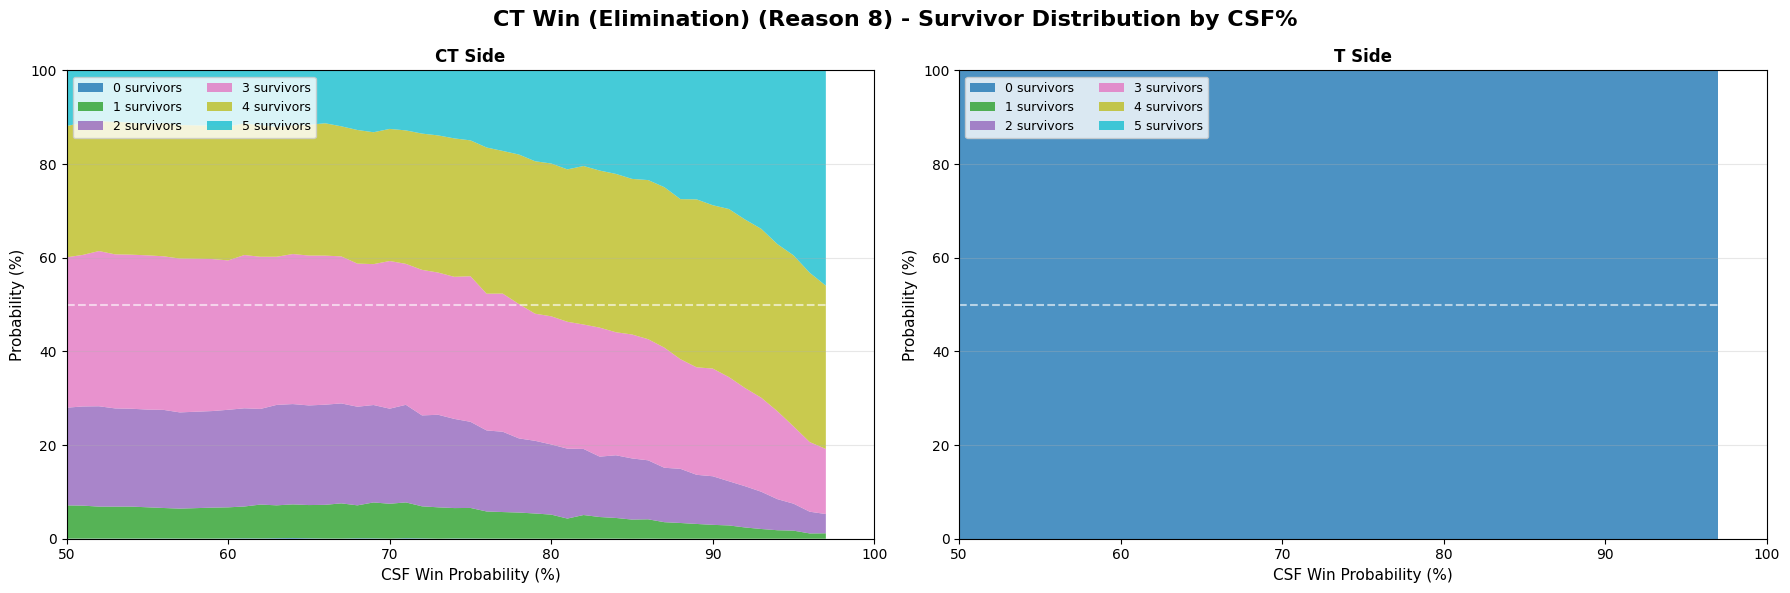

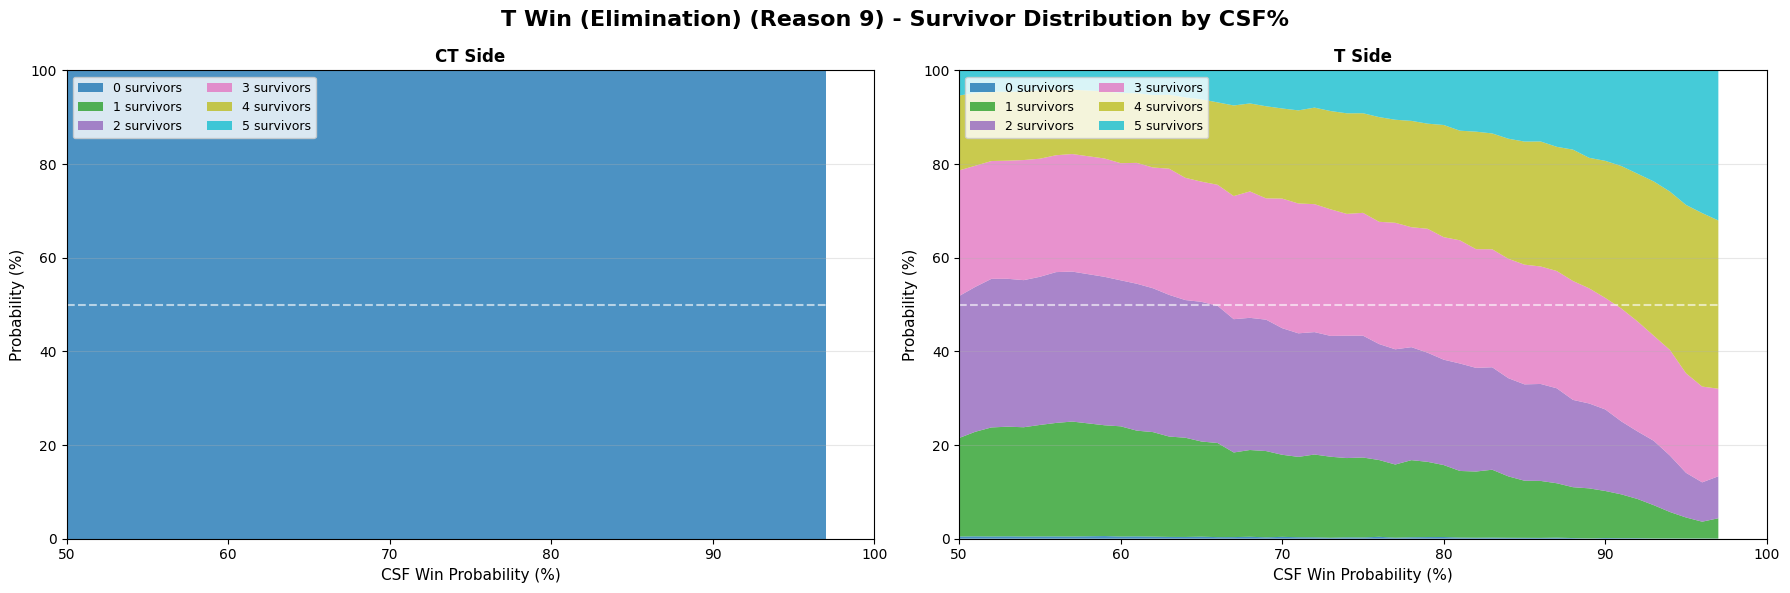

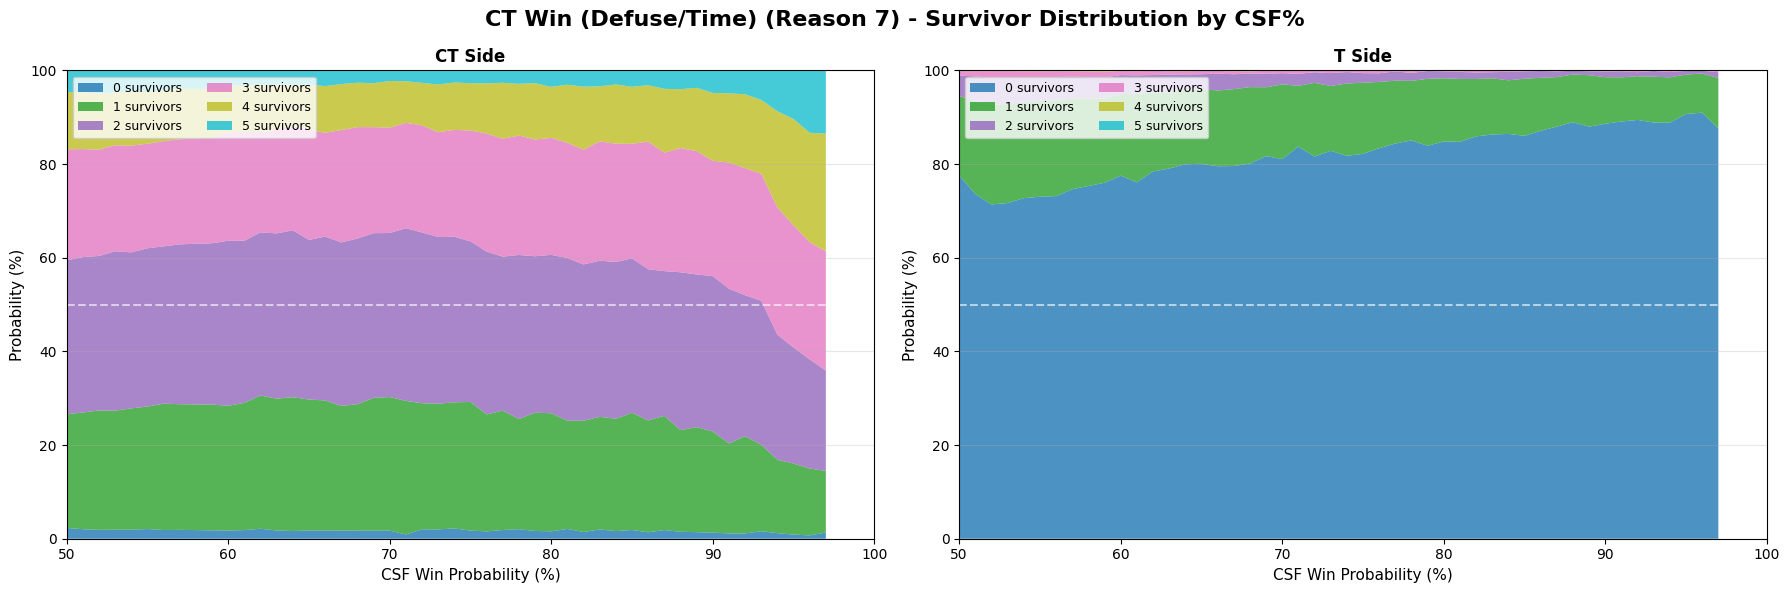

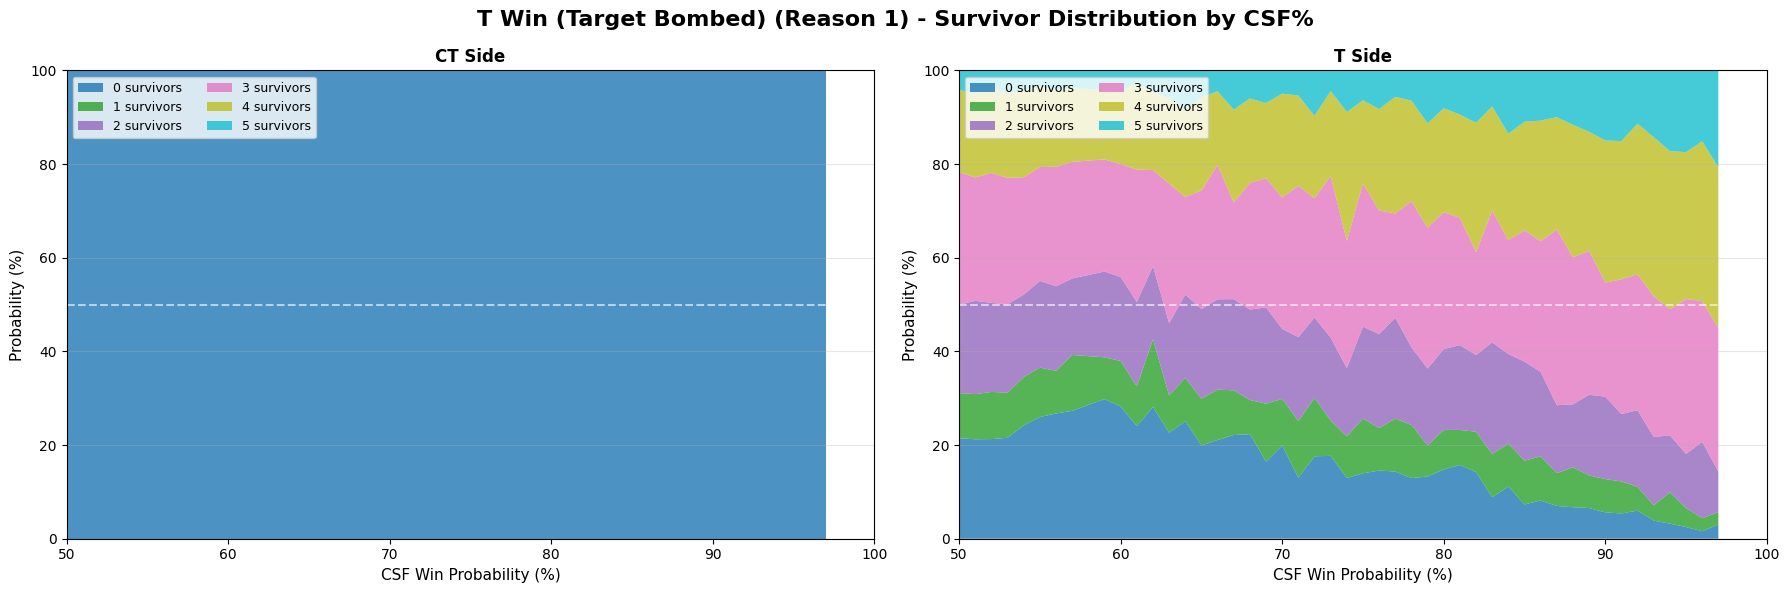

✅ Stacked distribution visualizations complete!



In [33]:
# Visualize survivor distributions with stacked area plots
print("📊 Creating stacked survivor distribution visualizations...")
print()

# Create visualizations for each round end reason
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'{reason_name} (Reason {reason}) - Survivor Distribution by CSF%', 
                 fontsize=16, fontweight='bold')
    
    # Plot for each side
    for side_idx, side in enumerate(['CT', 'T']):
        ax = axes[side_idx]
        
        if side in survivor_analysis and reason in survivor_analysis[side]:
            reason_data = survivor_analysis[side][reason]
            csf_data = reason_data.get('csf_distributions', {})
            
            if not csf_data:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=14)
                ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
                ax.set_ylabel('Probability (%)', fontsize=11)
                ax.set_title(f'{side} Side', fontsize=12, fontweight='bold')
                continue
            
            # Prepare data: for each survivor count (0-5), track probability across CSF percentages
            csf_percentages = sorted(csf_data.keys())
            survivor_probs = {i: [] for i in range(6)}
            
            for csf_pct in csf_percentages:
                dist_data = csf_data[csf_pct]
                cum_dist = dist_data['cumulative_distribution']
                
                for surv_count in range(6):
                    # Get probability (not cumulative)
                    prob = cum_dist[surv_count]['probability'] * 100
                    survivor_probs[surv_count].append(prob)
            
            # Create stacked area plot
            colors = plt.cm.tab10(np.linspace(0, 1, 6))
            
            # Stack the areas (convert to numpy arrays for stacking)
            y_data = np.array([survivor_probs[i] for i in range(6)])
            
            # Plot stacked areas
            ax.stackplot(csf_percentages, y_data, 
                        labels=[f'{i} survivors' for i in range(6)],
                        colors=colors, alpha=0.8)
            
            # Formatting
            ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
            ax.set_ylabel('Probability (%)', fontsize=11)
            ax.set_title(f'{side} Side', fontsize=12, fontweight='bold')
            ax.legend(loc='upper left', fontsize=9, ncol=2, bbox_to_anchor=(0, 1))
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_xlim(50, 100)
            ax.set_ylim(0, 100)
            
            # Add reference line at 50%
            ax.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=1.5)
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
            ax.set_ylabel('Probability (%)', fontsize=11)
            ax.set_title(f'{side} Side', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("✅ Stacked distribution visualizations complete!")
print()


📊 Creating survivor CDF visualizations...



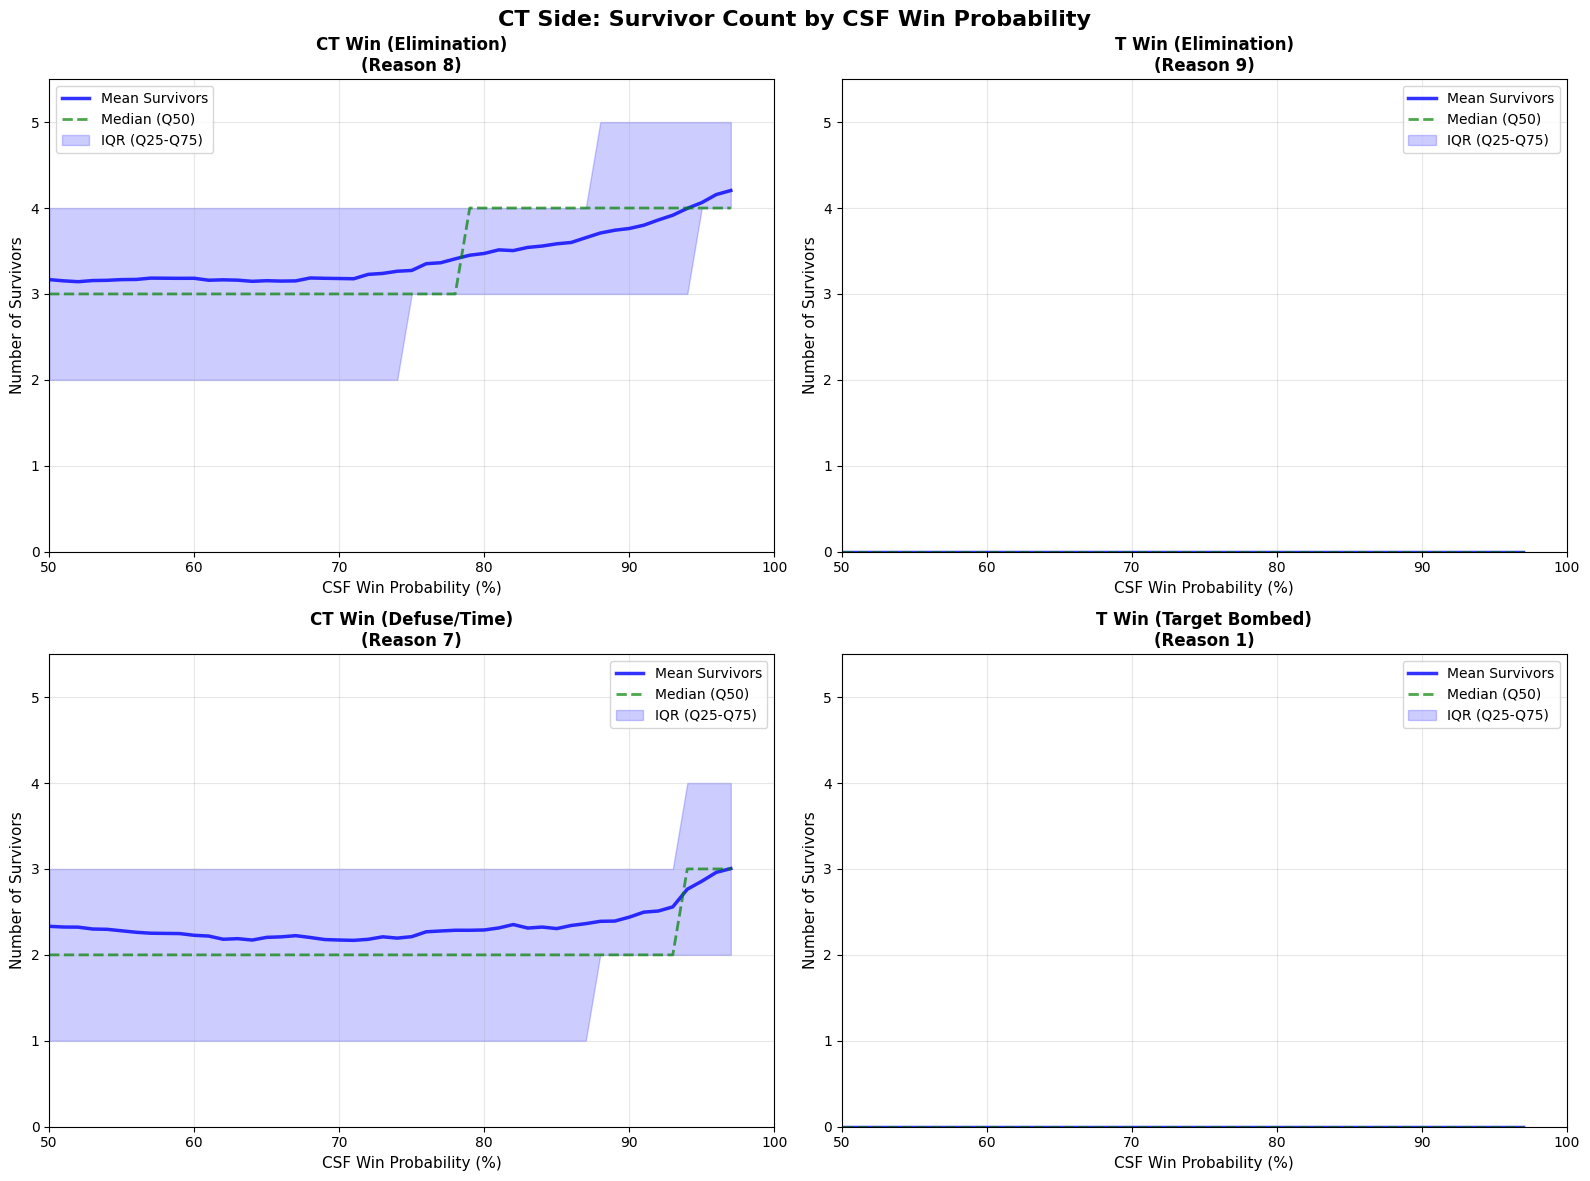

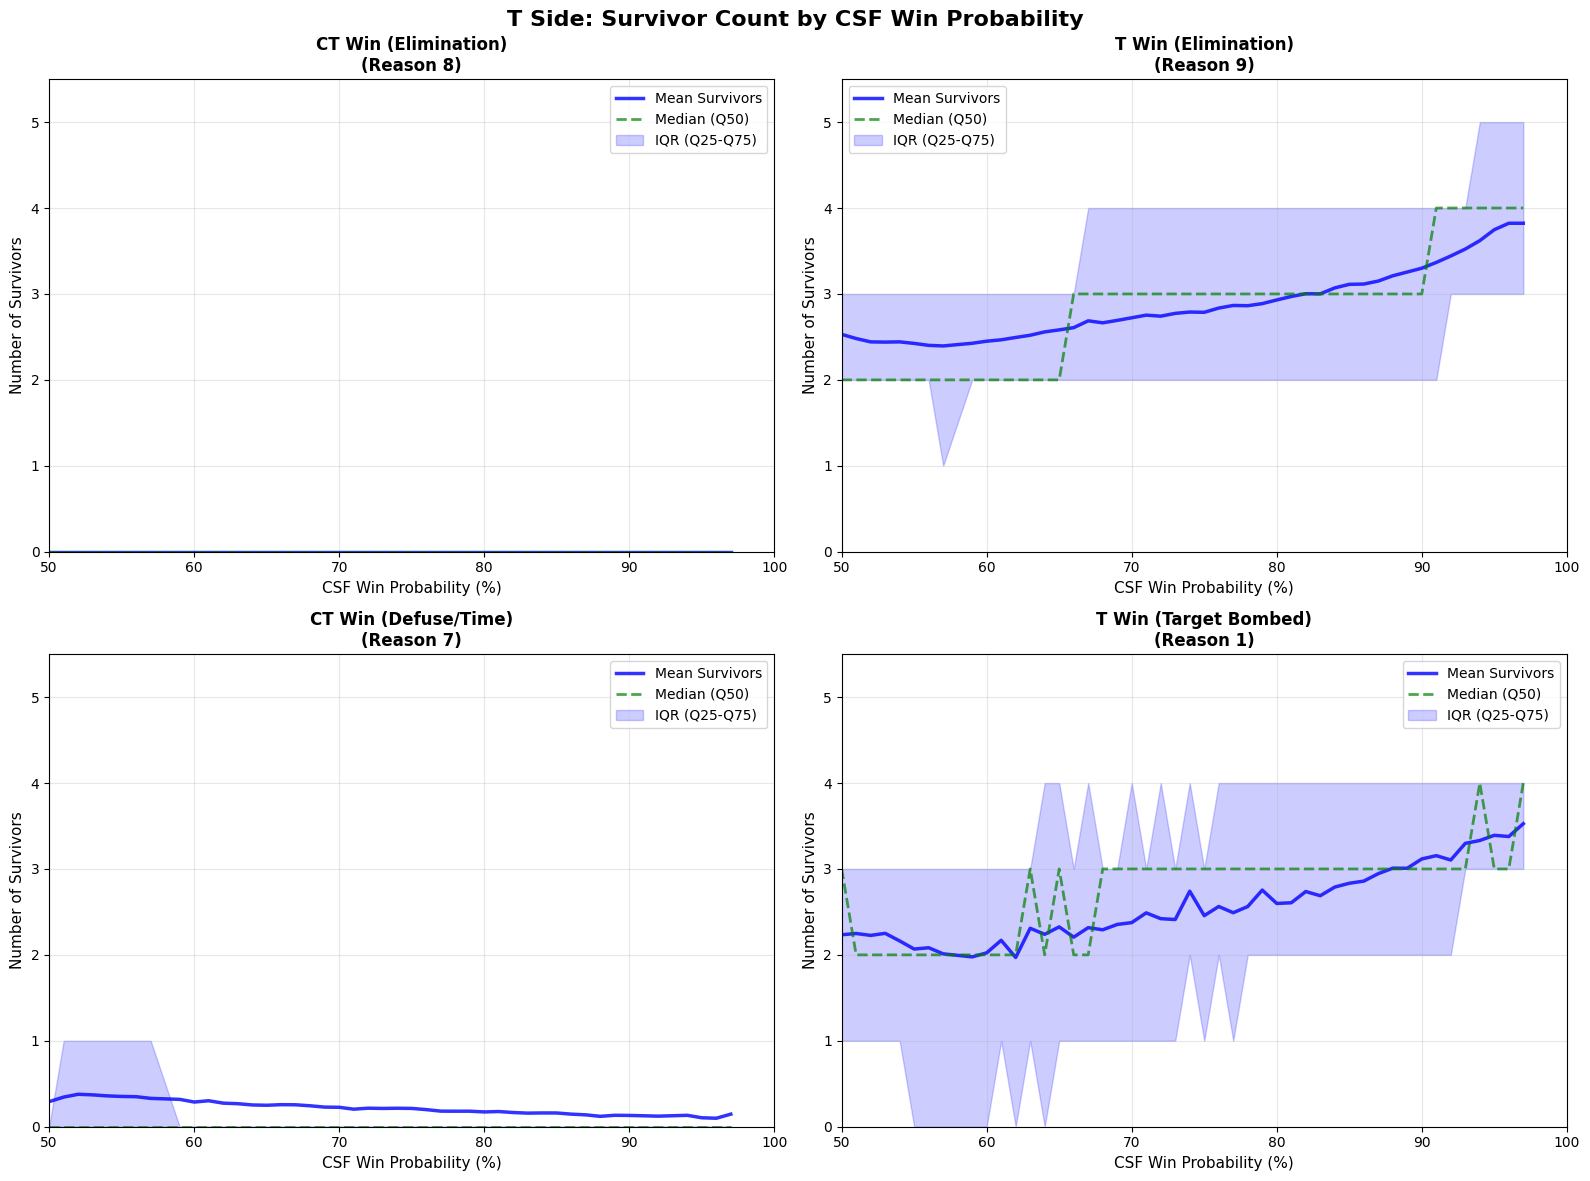

✅ Visualizations complete!

💡 KEY INSIGHTS:
   • CSF advantage affects survivor distribution
   • Different round end reasons show different patterns
   • Use these distributions in ABM to sample realistic survivor counts
   • Higher CSF advantage typically leads to more survivors


In [34]:
# Visualize survivor cumulative distributions by CSF percentage
print("📊 Creating survivor CDF visualizations...")
print()

for side in ['CT', 'T']:
    side_data = survivor_analysis[side]
    n_reasons = len(side_data)
    
    if n_reasons == 0:
        continue
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle(f'{side} Side: Survivor Count by CSF Win Probability', fontsize=16, fontweight='bold')
    
    for idx, (reason, reason_info) in enumerate(side_data.items()):
        if idx >= 4:
            break
        
        ax = axes[idx]
        reason_name = reason_info['reason_name']
        csf_data = reason_info['csf_distributions']
        
        # Extract data for plotting
        csf_percentages = sorted(csf_data.keys())
        mean_survivors = [csf_data[csf]['mean_survivors'] for csf in csf_percentages]
        
        # Plot mean survivors
        ax.plot(csf_percentages, mean_survivors, 'b-', linewidth=2.5, label='Mean Survivors', alpha=0.8)
        
        # Plot quantiles (25th, 50th, 75th percentiles derived from CDF)
        q25_survivors = []
        q50_survivors = []
        q75_survivors = []
        
        for csf in csf_percentages:
            cdf = csf_data[csf]['cumulative_distribution']
            
            # Find survivor counts at quantiles
            q25_surv = next((s for s in range(6) if cdf[s]['cumulative_probability'] >= 0.25), 5)
            q50_surv = next((s for s in range(6) if cdf[s]['cumulative_probability'] >= 0.50), 5)
            q75_surv = next((s for s in range(6) if cdf[s]['cumulative_probability'] >= 0.75), 5)
            
            q25_survivors.append(q25_surv)
            q50_survivors.append(q50_surv)
            q75_survivors.append(q75_surv)
        
        ax.plot(csf_percentages, q50_survivors, 'g--', linewidth=2, label='Median (Q50)', alpha=0.7)
        ax.fill_between(csf_percentages, q25_survivors, q75_survivors, alpha=0.2, color='blue', label='IQR (Q25-Q75)')
        
        ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
        ax.set_ylabel('Number of Survivors', fontsize=11)
        ax.set_title(f"{reason_name}\n(Reason {reason})", fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(50, 100)
        ax.set_ylim(0, 5.5)
        ax.set_yticks(range(0, 6))
    
    # Hide unused subplots
    for idx in range(len(side_data), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualizations complete!")
print()
print("💡 KEY INSIGHTS:")
print("   • CSF advantage affects survivor distribution")
print("   • Different round end reasons show different patterns")
print("   • Use these distributions in ABM to sample realistic survivor counts")
print("   • Higher CSF advantage typically leads to more survivors")

# Equipment Saved Per Survivor Analysis

Prepare data for quantile regression grouped by round end reason.

In [35]:
print("="*80)
print("📊 PREPARE EQUIPMENT SAVED DATA FOR QUANTILE REGRESSION")
print("="*80)
print()

# Prepare data for both CT and T sides with improved target variable
improved_regression_results = []

for side in ['CT', 'T']:
    print(f"🔹 Processing {side} side data...")
    
    # Select relevant columns
    if side == 'CT':
        df_side = detailed_df[['round_end_reason', 'ct_survivors', 'ct_equipment', 't_equipment', 'ct_saved_equipment']].copy()
        df_side.columns = ['round_end_reason', 'survivors', 'ct_equipment', 't_equipment', 'saved_equipment']
        df_side['is_ct'] = 1
    else:
        df_side = detailed_df[['round_end_reason', 't_survivors', 'ct_equipment', 't_equipment', 't_saved_equipment']].copy()
        df_side.columns = ['round_end_reason', 'survivors', 'ct_equipment', 't_equipment', 'saved_equipment']
        df_side['is_ct'] = 0
    
    # Remove rows with missing values, exclude rounds where no equipment was saved, or zero survivors
    df_side = df_side.dropna()
    df_side = df_side[(df_side['saved_equipment'] > 0) & (df_side['survivors'] > 0)].copy()
    
    # Calculate total equipment in the round
    df_side['total_equipment'] = df_side['ct_equipment'] + df_side['t_equipment']
    
    # Calculate equipment saved per survivor as % of total equipment
    df_side['saved_per_survivor_pct'] = (df_side['saved_equipment'] / df_side['survivors']) / df_side['total_equipment'] * 100
    
    # Remove false Data where saved equipment is more than total available (over 100%)
    df_side = df_side[df_side['saved_per_survivor_pct'] <= 100].copy()
    
    print(f"   Dataset: {len(df_side):,} rounds")
    print(f"   Mean: {df_side['saved_per_survivor_pct'].mean():.2f}% of total equipment saved per survivor")
    print()
    
    # Store results
    improved_regression_results.append({
        'side': side,
        'df_side': df_side
    })

print("✅ Data preparation complete")
print()

📊 PREPARE EQUIPMENT SAVED DATA FOR QUANTILE REGRESSION

🔹 Processing CT side data...


   Dataset: 1,167,446 rounds
   Mean: 12.28% of total equipment saved per survivor

🔹 Processing T side data...
   Dataset: 809,719 rounds
   Mean: 12.20% of total equipment saved per survivor

✅ Data preparation complete

   Dataset: 809,719 rounds
   Mean: 12.20% of total equipment saved per survivor

✅ Data preparation complete



In [36]:
print("="*80)
print("📊 EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION (ECDF) ANALYSIS")
print("📊 Equipment Saved Per Survivor (% of Total Equipment)")
print("="*80)
print()

# Store ECDF results for JSON export
equipment_distributions = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE - EQUIPMENT SAVED DISTRIBUTIONS")
    print(f"{'='*80}\n")
    
    equipment_distributions[side] = {}
    
    # Get data from improved regression
    df_side = improved_regression_results[0 if side == 'CT' else 1]['df_side'].copy()
    
    # Process each of the top 4 round end reasons
    for reason in top_reasons:
        reason_name = reason_names.get(reason, f"Reason {reason}")
        print(f"\n   {'─'*70}")
        print(f"   🎯 {reason_name} (Reason {reason})")
        print(f"   {'─'*70}")
        
        # Filter data for this round end reason
        df_reason = df_side[df_side['round_end_reason'] == reason].copy()
        
        if len(df_reason) < 50:  # Skip if insufficient data
            print(f"   ⚠️  Insufficient data ({len(df_reason)} rounds) - skipping")
            continue
        
        equipment_distributions[side][reason] = {
            'reason_name': reason_name,
            'survivor_distributions': {}
        }
        
        # Analyze for each survivor count (1-5)
        for surv in range(1, 6):
            df_surv = df_reason[df_reason['survivors'] == surv].copy()
            
            if len(df_surv) < 10:
                continue
            
            # Get equipment saved percentages
            eq_saved_pct = df_surv['saved_per_survivor_pct'].values
            
            # Calculate ECDF (Empirical Cumulative Distribution Function)
            sorted_data = np.sort(eq_saved_pct)
            ecdf_x = sorted_data
            ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Calculate statistics
            stats_dict = {
                'n_samples': len(eq_saved_pct),
                'mean': float(eq_saved_pct.mean()),
                'median': float(np.median(eq_saved_pct)),
                'std': float(eq_saved_pct.std()),
                'min': float(eq_saved_pct.min()),
                'max': float(eq_saved_pct.max()),
                'q25': float(np.percentile(eq_saved_pct, 25)),
                'q75': float(np.percentile(eq_saved_pct, 75)),
                # Store ECDF for export (sample to ~200 points for accuracy)
                'ecdf': {
                    'x': [float(x) for x in ecdf_x[::max(1, len(ecdf_x)//200)].tolist()],
                    'y': [float(y) for y in ecdf_y[::max(1, len(ecdf_y)//200)].tolist()]
                }
            }
            
            equipment_distributions[side][reason]['survivor_distributions'][surv] = stats_dict
            
            # Print summary
            print(f"\n   {surv} Survivor{'s' if surv > 1 else ''} (n={len(eq_saved_pct):,}):")
            print(f"      Mean: {stats_dict['mean']:.2f}%  |  Median: {stats_dict['median']:.2f}%  |  Std: {stats_dict['std']:.2f}%")
            print(f"      Range: [{stats_dict['min']:.2f}%, {stats_dict['max']:.2f}%]  |  IQR: [{stats_dict['q25']:.2f}%, {stats_dict['q75']:.2f}%]")
            print(f"      ECDF Points: {len(stats_dict['ecdf']['x'])}")

print("\n" + "="*80)
print("✅ ECDF ANALYSIS COMPLETE")
print("="*80)
print()
print("💡 Distributions stored for JSON export")
print("   • ECDF: Empirical Cumulative Distribution Function")
print("   • Use inverse transform sampling in ABM for stochastic equipment values")


📊 EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION (ECDF) ANALYSIS
📊 Equipment Saved Per Survivor (% of Total Equipment)


🔹 CT SIDE - EQUIPMENT SAVED DISTRIBUTIONS


   ──────────────────────────────────────────────────────────────────────
   🎯 CT Win (Elimination) (Reason 8)
   ──────────────────────────────────────────────────────────────────────

   1 Survivor (n=43,849):
      Mean: 12.74%  |  Median: 12.18%  |  Std: 3.59%
      Range: [0.75%, 55.62%]  |  IQR: [10.31%, 14.43%]
      ECDF Points: 201

   1 Survivor (n=43,849):
      Mean: 12.74%  |  Median: 12.18%  |  Std: 3.59%
      Range: [0.75%, 55.62%]  |  IQR: [10.31%, 14.43%]
      ECDF Points: 201

   2 Survivors (n=138,754):
      Mean: 11.85%  |  Median: 11.12%  |  Std: 3.33%
      Range: [0.91%, 46.02%]  |  IQR: [9.81%, 13.36%]
      ECDF Points: 201

   3 Survivors (n=235,829):
      Mean: 11.91%  |  Median: 10.86%  |  Std: 3.67%
      Range: [0.63%, 78.06%]  |  IQR: [9.66%, 14.16%]
      ECDF Points: 201

   2 Survivors (n=1

📊 Creating ECDF visualizations...



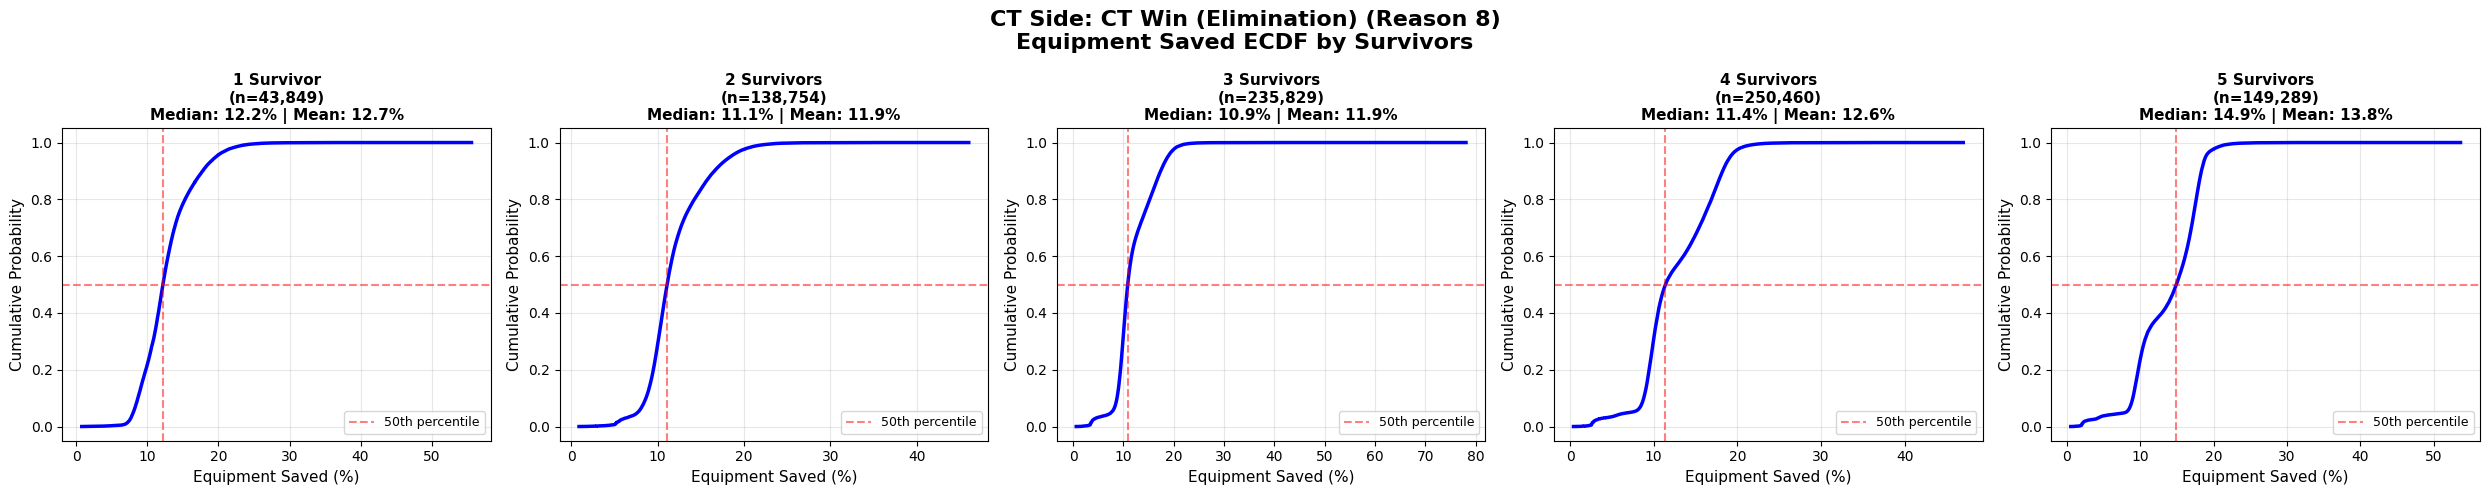

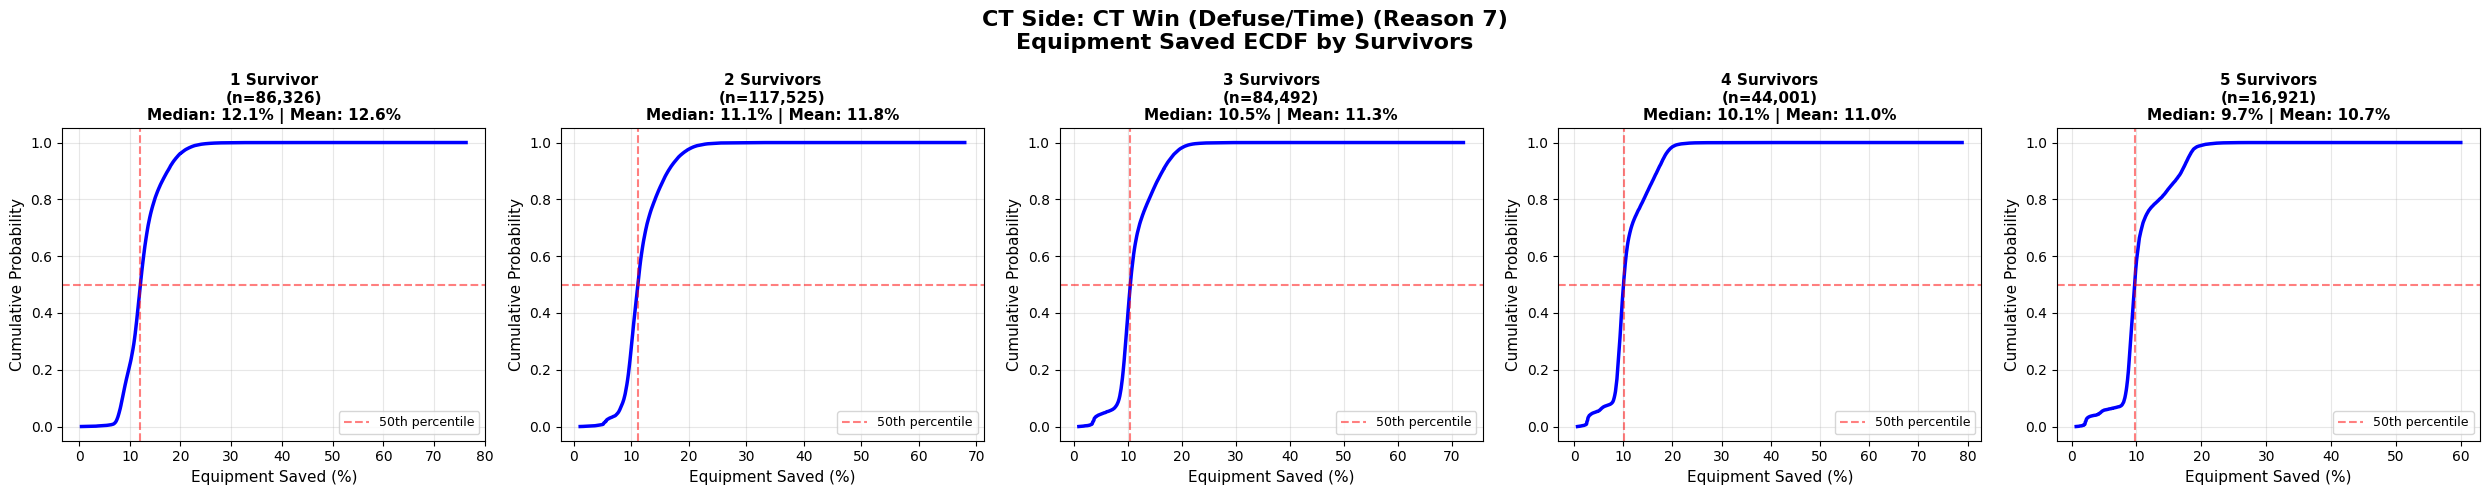

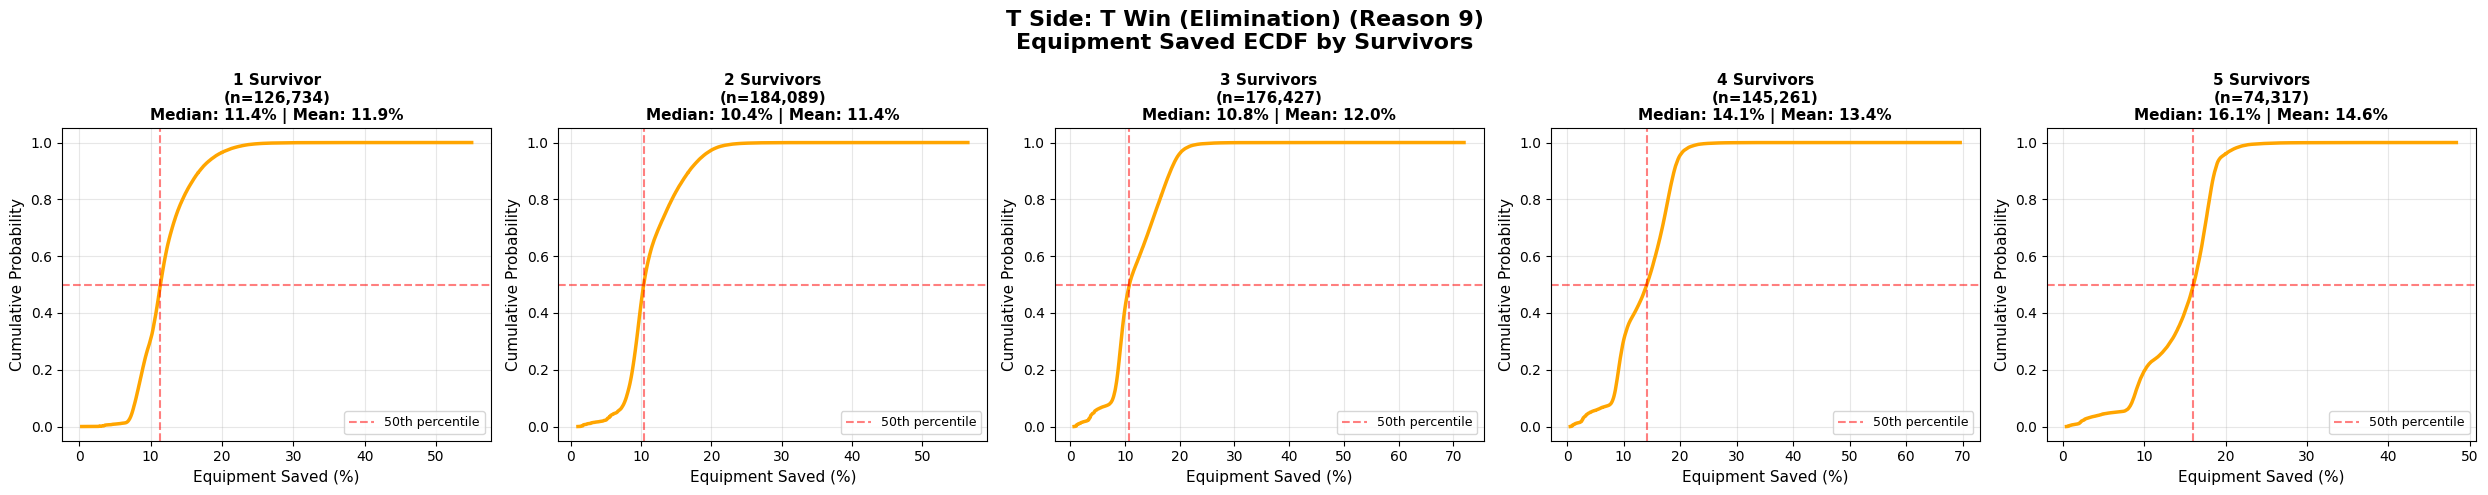

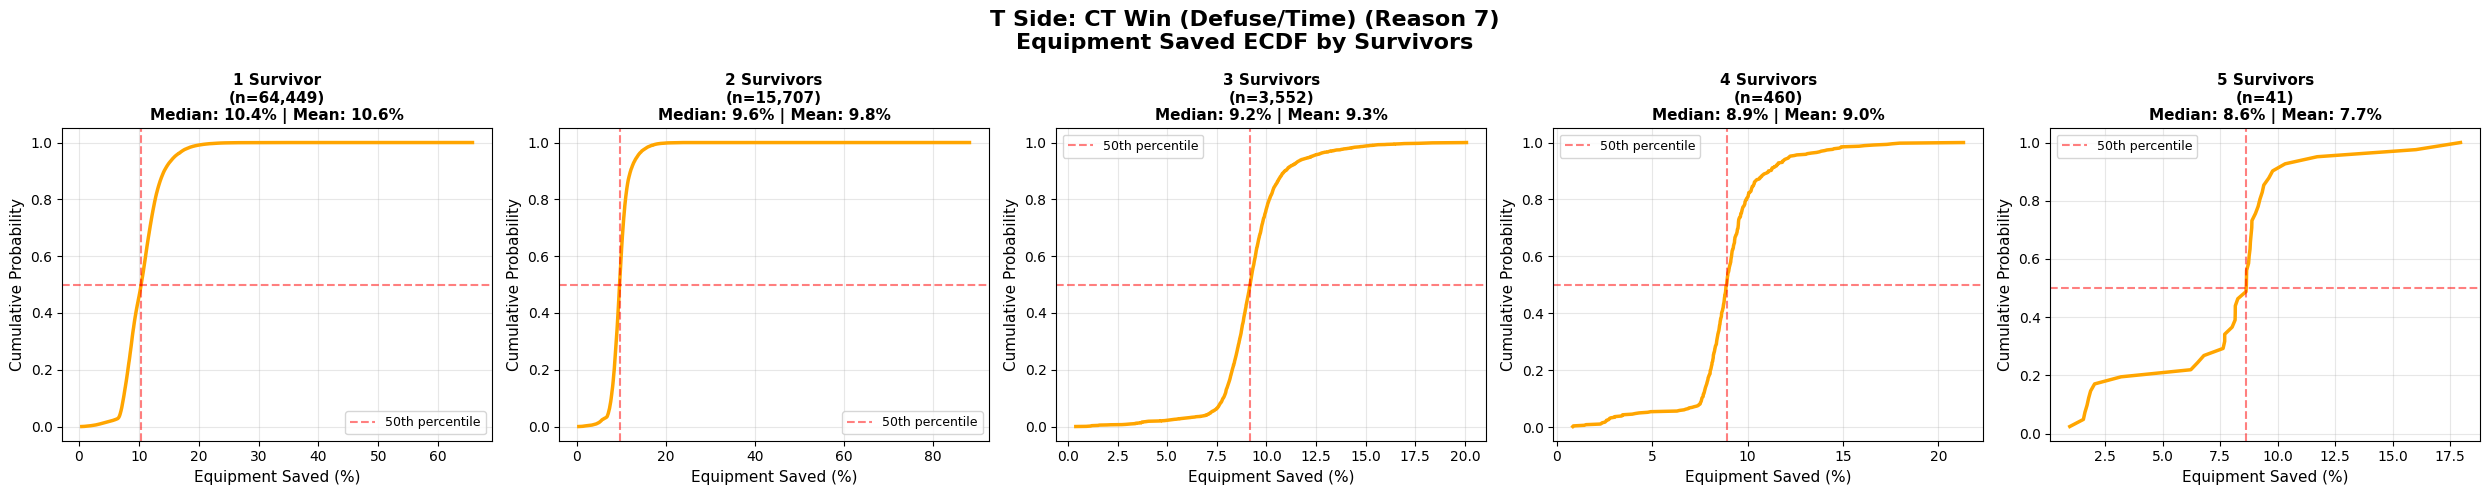

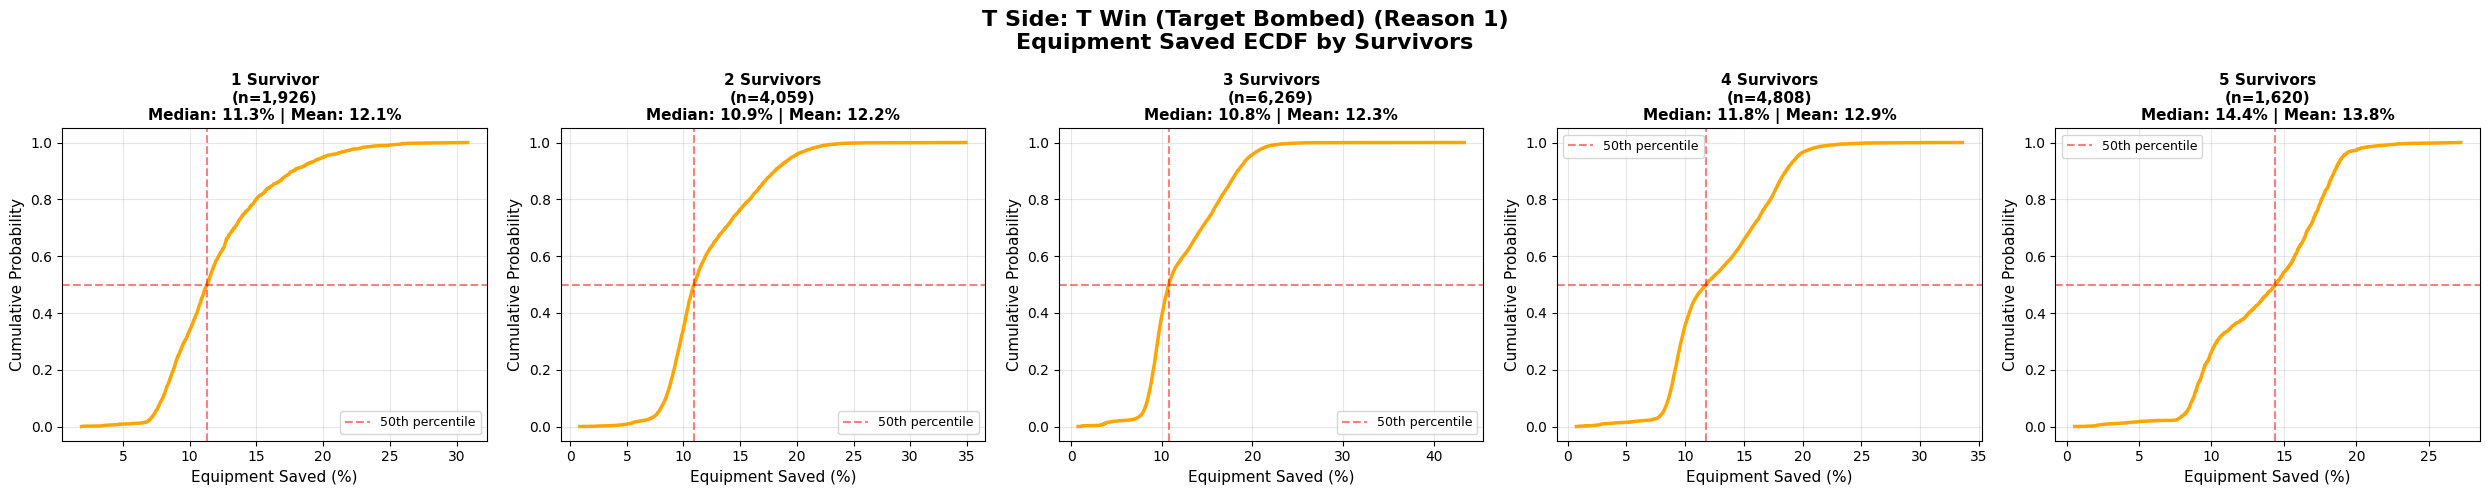

✅ ECDF visualizations complete!

💡 KEY INSIGHTS:
   • ECDF shows cumulative probability distribution from actual data
   • Red dashed lines mark the median (50th percentile)
   • Use inverse transform sampling in ABM: sample u~U(0,1), find x where ECDF(x)=u


In [37]:
# Visualize ECDF for equipment saved distributions
print("📊 Creating ECDF visualizations...")
print()

for side in ['CT', 'T']:
    if side not in equipment_distributions:
        continue
    
    side_data = equipment_distributions[side]
    
    # Create visualization for each round end reason
    for reason, reason_data in side_data.items():
        if isinstance(reason, int):  # Skip if not a reason number
            reason_name = reason_data['reason_name']
            surv_dists = reason_data['survivor_distributions']
            
            if not surv_dists:
                continue
            
            # Count how many survivors have data
            n_survivors = len(surv_dists)
            
            # Create subplots: 1 row for ECDF, n_survivors columns
            fig, axes = plt.subplots(1, n_survivors, figsize=(5*n_survivors, 5))
            if n_survivors == 1:
                axes = [axes]
            
            fig.suptitle(f'{side} Side: {reason_name} (Reason {reason})\nEquipment Saved ECDF by Survivors', 
                         fontsize=16, fontweight='bold')
            
            for idx, (surv, dist_data) in enumerate(sorted(surv_dists.items())):
                # Get the actual data for plotting
                df_side = improved_regression_results[0 if side == 'CT' else 1]['df_side']
                df_plot = df_side[(df_side['round_end_reason'] == reason) & 
                                  (df_side['survivors'] == surv)]
                eq_saved_pct = df_plot['saved_per_survivor_pct'].values
                
                if len(eq_saved_pct) < 10:
                    continue
                
                # ECDF Plot
                ax = axes[idx]
                sorted_data = np.sort(eq_saved_pct)
                ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
                ax.plot(sorted_data, ecdf_y, linewidth=2.5, color='blue' if side == 'CT' else 'orange')
                ax.set_xlabel('Equipment Saved (%)', fontsize=11)
                ax.set_ylabel('Cumulative Probability', fontsize=11)
                ax.set_title(f'{surv} Survivor{"s" if surv > 1 else ""}\n(n={dist_data["n_samples"]:,})\n' +
                           f'Median: {dist_data["median"]:.1f}% | Mean: {dist_data["mean"]:.1f}%', 
                           fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
                ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='50th percentile')
                ax.axvline(x=dist_data['median'], color='red', linestyle='--', alpha=0.5, linewidth=1.5)
                ax.legend(loc='best', fontsize=9)
            
            plt.tight_layout()
            plt.show()

print("✅ ECDF visualizations complete!")
print()
print("💡 KEY INSIGHTS:")
print("   • ECDF shows cumulative probability distribution from actual data")
print("   • Red dashed lines mark the median (50th percentile)")
print("   • Use inverse transform sampling in ABM: sample u~U(0,1), find x where ECDF(x)=u")

In [ ]:
import json

# Export all analysis results to JSON for Go ABM
print("="*80)
print("📤 EXPORTING ALL ABM DATA TO JSON")
print("="*80)
print()

# Define round end reason code conversion mapping
# Maps database reasons to export reasons for ABM
REASON_CODE_MAPPING = {
    1: 1,  # T Win (Target Bombed) - no change
    7: 3,  # CT Win (Defuse) - 7 → 3
    8: 4,  # CT Win (Elimination) - 8 → 4
    9: 2,  # T Win (Elimination) - 9 → 2
}

REASON_NAMES = {
    1: "T Win (Target Bombed)",
    2: "T Win (Elimination)",
    3: "CT Win (Defuse)",
    4: "CT Win (Elimination)",
}

print("🔹 Round end reason code mapping:")
for old_code, new_code in REASON_CODE_MAPPING.items():
    print(f"   {old_code} → {new_code}: {REASON_NAMES[new_code]}")
print()

# Convert numpy types to native Python types for JSON
def convert_to_native_types(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    else:
        return obj

# Convert CSF percentages from string keys to integers (50-100)
def convert_csf_keys_to_int(analysis_dict):
    """Convert CSF percentage keys from any format to integers 50-100"""
    converted = {}
    for key, value in analysis_dict.items():
        if isinstance(key, str) and key.isdigit():
            int_key = int(key)
            if 50 <= int_key <= 100:
                converted[int_key] = convert_to_native_types(value)
        elif isinstance(key, int) and 50 <= key <= 100:
            converted[key] = convert_to_native_types(value)
        else:
            # Keep non-CSF keys as-is (e.g., 'CT', 'T', reason numbers)
            converted[key] = convert_to_native_types(value) if isinstance(value, dict) else value
    return converted

def convert_reason_codes_in_dict(data_dict):
    """Convert round end reason codes in nested dictionary structures"""
    converted = {}
    for key, value in data_dict.items():
        # If key is a reason code that needs conversion
        if isinstance(key, int) and key in REASON_CODE_MAPPING:
            new_key = REASON_CODE_MAPPING[key]
            converted[new_key] = convert_to_native_types(value)
            # Update reason_name if present
            if isinstance(value, dict) and 'reason_name' in value:
                converted[new_key]['reason_name'] = REASON_NAMES[new_key]
        else:
            converted[key] = convert_to_native_types(value)
    return converted

print("🔹 Converting round end reason analysis...")
round_end_reason_export = {}
for side, side_data in round_end_reason_analysis.items():
    round_end_reason_export[side] = {}
    for csf_pct, csf_data in side_data.items():
        csf_converted = convert_csf_keys_to_int({csf_pct: csf_data})[csf_pct]
        if 'reason_distribution' in csf_converted:
            csf_converted['reason_distribution'] = convert_reason_codes_in_dict(csf_converted['reason_distribution'])
        round_end_reason_export[side][csf_pct] = csf_converted

print("🔹 Converting bomb planted analysis...")
bomb_planted_export = {}
for side, side_data in bomb_planted_analysis.items():
    bomb_planted_export[side] = {}
    for csf_pct, csf_data in side_data.items():
        csf_converted = convert_csf_keys_to_int({csf_pct: csf_data})[csf_pct]
        # Bomb planted is only for reason 9 (elimination), convert to reason 2
        bomb_planted_export[side][csf_pct] = csf_converted

print("🔹 Converting survivor analysis...")
survivor_distributions_export = {}
for side, side_data in survivor_analysis.items():
    survivor_distributions_export[side] = {}
    for reason, reason_data in side_data.items():
        new_reason = REASON_CODE_MAPPING.get(reason, reason)
        survivor_distributions_export[side][new_reason] = {
            'reason_name': REASON_NAMES.get(new_reason, reason_data['reason_name']),
            'csf_distributions': convert_csf_keys_to_int(reason_data['csf_distributions'])
        }

print("🔹 Converting equipment distributions (ECDF)...")
equipment_distributions_export = {}
for side, side_data in equipment_distributions.items():
    equipment_distributions_export[side] = {}
    for reason, reason_data in side_data.items():
        if isinstance(reason, int) and reason in REASON_CODE_MAPPING:
            new_reason = REASON_CODE_MAPPING[reason]
            equipment_distributions_export[side][new_reason] = convert_to_native_types(reason_data)
            equipment_distributions_export[side][new_reason]['reason_name'] = REASON_NAMES[new_reason]
        else:
            equipment_distributions_export[side][reason] = convert_to_native_types(reason_data)

# Build main export structure
export_data = {
    "metadata": {
        "csf_r_value": float(csf_r_value),
        "avg_ct_equipment": float(detailed_df['ct_equipment'].mean()),
        "avg_t_equipment": float(detailed_df['t_equipment'].mean()),
        "csf_range": "50-100 (integer percentages)",
        "export_date": str(pd.Timestamp.now().date()),
        "total_rounds": len(detailed_df),
        "round_end_reason_mapping": {
            "description": "Mapping from database reason codes to export reason codes",
            "mappings": {
                str(old): {"new_code": new, "name": REASON_NAMES[new]} 
                for old, new in REASON_CODE_MAPPING.items()
            }
        }
    },
    "round_end_reason_distributions": round_end_reason_export,
    "bomb_planted_distributions": bomb_planted_export,
    "survivor_distributions": survivor_distributions_export,
    "equipment_saved_distributions": equipment_distributions_export
}

# Save to JSON file
print("🔹 Writing to file...")
with open('abm_models.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print()
print("="*80)
print("✅ EXPORTED TO: abm_models.json")
print("="*80)
print()
print("📊 ROUND END REASON CODES (EXPORTED):")
print("   1: T Win (Target Bombed)")
print("   2: T Win (Elimination)          [was 9 in database]")
print("   3: CT Win (Defuse/Time)         [was 7 in database]")
print("   4: CT Win (Elimination)         [was 8 in database]")
print()
print("📊 DATA STRUCTURE:")
print("   • metadata:")
print("     - csf_r_value: CSF parameter for win probability")
print("     - avg_ct_equipment, avg_t_equipment: Reference values")
print("     - csf_range: '50-100' (integer percentages)")
print("     - round_end_reason_mapping: Code conversion map with names")
print()
print("   • round_end_reason_distributions[side][csf_pct]:")
print("     - n_rounds: Number of rounds")
print("     - reason_distribution[reason_id]: {count, probability, reason_name}")
print("       (reason_id uses exported codes: 1, 2, 3, 4)")
print()
print("   • bomb_planted_distributions[side][csf_pct]:")
print("     - n_rounds: Number of rounds")
print("     - bomb_planted_count, bomb_planted_probability")
print("     - bomb_not_planted_probability")
print()
print("   • survivor_distributions[side][reason][csf_distributions][csf_pct]:")
print("     - reason: Uses exported codes (1, 2, 3, 4)")
print("     - n_samples: Number of rounds")
print("     - mean_survivors, median_survivors")
print("     - cumulative_distribution[survivor_count]: {count, probability, cumulative_probability}")
print()
print("   • equipment_saved_distributions[side][reason][survivor_distributions][survivors]:")
print("     - reason: Uses exported codes (1, 2, 3, 4)")
print("     - n_samples, mean, median, std, min, max, q25, q75")
print("     - ecdf: {x: [values], y: [cumulative_probs]} - Empirical CDF for sampling")
print()
print("💡 ABM SAMPLING WORKFLOW:")
print("   1. Calculate CSF win probability based on equipment")
print("   2. Round CSF to nearest integer (50-100)")
print("   3. Determine winner (CT or T) based on CSF")
print("   4. Sample round_end_reason from distributions[side][csf_pct]")
print("      → Returns codes: 1 (T Bomb), 2 (T Elim), 3 (CT Defuse), 4 (CT Elim)")
print("   5. Sample survivor count from survivor_distributions[side][reason][csf_pct]")
print("   6. Sample bomb_planted from bomb_planted_distributions[side][csf_pct]")
print("   7. Sample equipment_saved using inverse transform sampling on ECDF:")
print("      - Generate random u ~ Uniform(0,1)")
print("      - Binary search ECDF to find x where ECDF(x) = u")
print("      - This gives a sample from the empirical distribution")

📤 EXPORTING ALL ABM DATA TO JSON

🔹 Converting round end reason analysis...
🔹 Converting bomb planted analysis for reason 9...
🔹 Converting survivor analysis...
🔹 Converting equipment distributions (ECDF)...
🔹 Writing to file...

✅ EXPORTED TO: abm_models.json

📊 DATA STRUCTURE:
   • metadata:
     - csf_r_value: CSF parameter for win probability
     - avg_ct_equipment, avg_t_equipment: Reference values
     - csf_range: '50-100' (integer percentages)

   • round_end_reason_distributions[side][csf_pct]:
     - n_rounds: Number of rounds
     - reason_distribution[reason_id]: {count, probability, reason_name}

   • bomb_planted_distributions[side][csf_pct]:
     - n_rounds: Number of rounds
     - bomb_planted_count, bomb_planted_probability
     - bomb_not_planted_probability

   • survivor_distributions[side][reason][csf_distributions][csf_pct]:
     - n_samples: Number of rounds
     - mean_survivors, median_survivors
     - cumulative_distribution[survivor_count]: {count, probabili